In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pyhive import presto
from pymongo import MongoClient
import warnings
warnings.filterwarnings("ignore")
import my_func

presto_conn = presto.connect(
    host='bi-presto.serving.data.production.internal',
    port=80,
    protocol='http',
    catalog='hive',
    username='mayank.jha@rapido.bike',
    # requests_kwargs=req_kw,
)

In [4]:
# load the segment data

df_segment = pd.read_csv('captain_pool.csv')
df_segment.head()

,captainid,login_hours,ride_days,idle_hours,yyyymmdd,Total_Pings,True_total_pings,accepted_pings,dropped_orders,Total_Pings_Link,True_total_pings_link,accepted_pings_link,dropped_orders_link,Total_Pings_Delivery,True_total_pings_delivery,accepted_pings_delivery,dropped_orders_delivery,earnings,active_day,captain_class
0,5737c6deddbec2203f73331a,216.90,4,54.25,80843987,20,17,8,5,20,17,8,5,0,0,0,0,5167,3,None
1,573f29009b0ffc2836772293,7.92,2,7.92,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Churned
2,573f290b9b0ffc2836775123,77.33,2,6.60,20210926,3,3,3,3,3,3,3,3,0,0,0,0,1281,1,Inactive
3,573f29179b0ffc28367780c6,4846.14,26,785.78,525485768,267,234,153,112,259,226,146,105,8,8,7,7,87126,26,PT Casual
4,573f29189b0ffc2836778230,8647.49,31,1976.67,586118799,377,333,275,197,377,333,275,197,0,0,0,0,152696,28,FT Occasional


In [31]:
start_date = '2021-09-06'
end_date = '2022-01-02'
captains_list = ['''''' + c + '''''' for c in df_segment['captainid'].unique()]
captains_list_1 = captains_list[:len(captains_list)//2]
captains_list_2 = captains_list[len(captains_list)//2:]

In [5]:
# Rides

def get_rides(start_date, end_date):
    
    print("fetching rides data for : ", start_date, " to ", end_date)
    rides_query = """select captain_id,
                            cast(weekday as integer) as weekday,
                            cast(hour as integer) as hour,
                            date_format(date_parse(order_date,'%Y-%m-%d'),'%Y%m%d') as order_date,
                            sum(case when service_obj_service_name = 'Link' then 1 else 0 end) as link_orders,
                            sum(case when service_obj_service_name in ('Delivery', 'Zomato') then 1 else 0 end) as delivery_orders,
                            count(*) as total_orders,
                            avg(coalesce(customer_feedback_rating, 5)) as rating
                        from orders.order_logs_snapshot
                        where order_date >= '{sd}'
                            and order_date <= '{ed}'
                            and order_status = 'dropped'
                            and (spd_fraud_flag != true or spd_fraud_flag is null)
                            and lower(service_obj_service_name) not like '%auto%'
                            and lower(order_type) not like '%auto%'
                        group by 1,2,3,4 """.format(sd=start_date, ed=end_date)
    #print(rides_query)
    tmp = pd.read_sql(rides_query, presto_conn)
    print(" fetched rides for captains", len(tmp))

    return tmp


df_rides = pd.DataFrame()

date_list = [pd.to_datetime(start_date) + timedelta(days=x) for x in range((pd.to_datetime(end_date)-pd.to_datetime(start_date)).days + 1)
        if (pd.to_datetime(start_date) + timedelta(days=x)).weekday() == 0]
date_list = [x.strftime('%Y-%m-%d') for x in date_list]

for day in date_list: 
    rides = get_rides(day, (pd.to_datetime(day) + timedelta(6)).strftime('%Y-%m-%d'))
    df_rides = pd.concat([df_rides, rides])

df_rides = df_rides.drop_duplicates(['captain_id', 'weekday', 'hour', 'order_date'])
print(df_rides.shape)

fetching rides data for :  2021-09-06  to  2021-09-12
 fetched rides for captains 909003
fetching rides data for :  2021-09-13  to  2021-09-19
 fetched rides for captains 939794
fetching rides data for :  2021-09-20  to  2021-09-26
 fetched rides for captains 948878
fetching rides data for :  2021-09-27  to  2021-10-03
 fetched rides for captains 992854
fetching rides data for :  2021-10-04  to  2021-10-10
 fetched rides for captains 1021402
fetching rides data for :  2021-10-11  to  2021-10-17
 fetched rides for captains 867639
fetching rides data for :  2021-10-18  to  2021-10-24
 fetched rides for captains 975553
fetching rides data for :  2021-10-25  to  2021-10-31
 fetched rides for captains 1205257
fetching rides data for :  2021-11-01  to  2021-11-07
 fetched rides for captains 961190
fetching rides data for :  2021-11-08  to  2021-11-14
 fetched rides for captains 1158985
fetching rides data for :  2021-11-15  to  2021-11-21
 fetched rides for captains 1097640
fetching rides da

TypeError: 'tuple' object is not callable

In [23]:
df_rides.to_csv('rides_data_for_pt_ft_segment_validation.csv', index=False)

In [7]:
# Login hours

def get_login_hours(start_date, end_date):
    print("fetching Login hours for : ",start_date, " to ", end_date)
    lh_query = """   select 
            userid as rider, 
            yyyymmdd,
            day_of_week(date(date_parse(yyyymmdd,'%Y%m%d'))) as day_of_week,
            cast(sum(duration) as double)/cast((60*60*1000) as double) as login_hours,
            sum(case when quarter_hour >= '0600' and quarter_hour <= '1159' then duration else 0 end)/cast((60*60*1000) as double) as morning_duration,
            sum(case when quarter_hour >= '1200' and quarter_hour <= '1659' then duration else 0 end)/cast((60*60*1000) as double) as afternoon_duration,
            sum(case when quarter_hour >= '1700' and quarter_hour <= '2359' then duration else 0 end)/cast((60*60*1000) as double) as evening_duration
        from hive.datasets.captain_login_hours
        where yyyymmdd >= '{sd}' 
            and yyyymmdd <= '{ed}'
            and status in ('2','3','6','7','8','10')
        group by 1,2,3      
               """.format(sd=start_date.replace('-',''), ed=end_date.replace('-',''))
    
    tmp = pd.read_sql(lh_query, presto_conn)
    print(" fetched Login hours", len(tmp))

    return tmp

df_login_hours = pd.DataFrame()

date_list = [pd.to_datetime(start_date) + timedelta(days=x) for x in range((pd.to_datetime(end_date)-pd.to_datetime(start_date)).days + 1)
        if (pd.to_datetime(start_date) + timedelta(days=x)).weekday() == 0]
date_list = [x.strftime('%Y-%m-%d') for x in date_list]

for day in date_list: 
    login_hours = get_login_hours(day.replace('-',''), (pd.to_datetime(day) + timedelta(6)).strftime('%Y-%m-%d').replace('-',''))
    df_login_hours = pd.concat([df_login_hours, login_hours])

df_login_hours = df_login_hours.drop_duplicates(['rider', 'yyyymmdd', 'day_of_week'])
print(df_login_hours.shape)

fetching Login hours for :  20210906  to  20210912
 fetched Login hours 865740
fetching Login hours for :  20210913  to  20210919
 fetched Login hours 888776
fetching Login hours for :  20210920  to  20210926
 fetched Login hours 935026
fetching Login hours for :  20210927  to  20211003
 fetched Login hours 956466
fetching Login hours for :  20211004  to  20211010
 fetched Login hours 915684
fetching Login hours for :  20211011  to  20211017
 fetched Login hours 820951
fetching Login hours for :  20211018  to  20211024
 fetched Login hours 893402
fetching Login hours for :  20211025  to  20211031
 fetched Login hours 976737
fetching Login hours for :  20211101  to  20211107
 fetched Login hours 813087
fetching Login hours for :  20211108  to  20211114
 fetched Login hours 899541
fetching Login hours for :  20211115  to  20211121
 fetched Login hours 935426
fetching Login hours for :  20211122  to  20211128
 fetched Login hours 1013764
fetching Login hours for :  20211129  to  20211205


In [24]:
df_login_hours.to_csv('lh_data_for_pt_ft_segment_validation.csv', index=False)

In [38]:
# First login cluster

def get_first_login_cluster(start_date, end_date):
    print("fetching first login cluster for : ",start_date, " to ", end_date)
    first_login_query = '''
        select * from (select a.captain_id, a.yyyymmdd, a.service, b.cluster, a.epoch, a.quarter_hour,
        row_number() over (partition by a.captain_id, a.yyyymmdd order by epoch) as r_no
        from hive.datasets.supplycursory_history a
        inner join (select hex_id, cluster 
                from hive.datasets.city_cluster_hex
                where resolution = 8) b
        on a.location = b.hex_id
        where a.status in (2, 3, 6, 7, 8, 10)
            and quarter_hour >= '0500'
            and quarter_hour <= '1100'
            and yyyymmdd >= '{sd}' 
            and yyyymmdd <= '{ed}'
        ) x
        where x.r_no = 1
    '''.format(sd=start_date.replace('-',''), ed=end_date.replace('-',''))
    
    tmp = pd.read_sql(first_login_query, presto_conn)
    print(" fetched first login cluster", len(tmp))

    return tmp


df_first_cluster = pd.DataFrame()

date_list = [pd.to_datetime(start_date) + timedelta(days=x) for x in range((pd.to_datetime(end_date)-pd.to_datetime(start_date)).days + 1)
        if (pd.to_datetime(start_date) + timedelta(days=x)).weekday() == 0]
date_list = [x.strftime('%Y-%m-%d') for x in date_list]

for day in date_list: 
    first_cluster = get_first_login_cluster(day, (pd.to_datetime(day) + timedelta(6)).strftime('%Y-%m-%d'))
    df_first_cluster = pd.concat([df_first_cluster, first_cluster])

df_first_cluster = df_first_cluster.drop_duplicates(['captain_id', 'yyyymmdd'])
print(df_first_cluster.shape)

fetching first login cluster for :  2021-09-06  to  2021-09-12


KeyboardInterrupt: 

In [10]:
# LTR and Activation Date

def get_ltr():
    #print('fetching LTR for : ',city)
    orders_query = """   select captainId,
                                registrationdate, 
                                activationdate,
                                date_diff('day', date(activationdate), current_date) as days_on_platform,
                                lastridedate,
                                lifetimerides as ltr,
                                preferredtimebucket,
                                case when weekdaycaptain = true then 'weekday'
                                     when weekendcaptain = true then 'weekend'
                                     else 'undecided' end as prefferedday
                            from datasets.captain_single_view 
                            where activationdate is not null
           
               """.format()
    
    tmp = pd.read_sql(orders_query, presto_conn)
    print(' fetched LTR & activation date ', len(tmp))

    return tmp


df_ltr = get_ltr()

print(df_ltr.shape)

 fetched LTR & activation date  2543817
(2543817, 8)


In [25]:
df_ltr.to_csv('ltr_data_for_pt_ft_segment_validation.csv', index=False)

In [21]:
# Pings

def get_pings(start_date, end_date):
    print("fetching rides data for : ", start_date, " to ", end_date)
    pings_query = """select captain_id, yyyymmdd,
        case when quarter_hour >= '0000' and quarter_hour < '0600' then 'night' 
             when quarter_hour >= '0600' and quarter_hour < '1200' then 'morning_peak' 
             when quarter_hour >= '1200' and quarter_hour < '1700' then 'afternoon' 
             when quarter_hour >= '1700' and quarter_hour < '2200' then 'evening_peak' 
             when quarter_hour >= '2200' and quarter_hour <= '2345' then 'night' end as time_of_day,
        (sum(case when event_type='dropped' then cast(amount as double) else 0.0 end)) as total_order_earnings,
        (sum(case when service_obj_service_name = 'Link' and event_type='dropped' then cast(amount as double) else 0.0 end)) as link_order_earnings,
        (sum(case when service_obj_service_name in ('Delivery', 'Zomato') and event_type='dropped' then cast(amount as double) else 0.0 end)) as delivery_order_earnings,
        (sum(case when event_type in ('accepted') then 1 else 0 end)
            + sum(case when event_type in ('rider_busy') then 1 else 0 end)
            + sum(case when event_type in ('rider_reject') then 1 else 0 end)) as Total_Pings,
        (count(distinct(case when event_type='dropped' then order_id end))+
            (count(distinct(case when event_type='rider_busy' then order_id end)))+
            (count(distinct(case when event_type='rider_reject' then order_id end)))+
            (count(distinct(case when event_type='rider_cancelled' then order_id end)))+
            (count(distinct(case when event_type='customer_cancelled' and cancel_reason in ('Asked to change payment mode','Asked to pay extra','Drop location denied','Asked to cancel and take offline ride','Taking longer than expected') then order_id end)))) as True_total_pings,
        (count(distinct(case when event_type='accepted' then order_id end))) as accepted_pings,
        (count(distinct(case when event_type='dropped' then order_id end))) as dropped_orders,
        (count(distinct(case when event_type='rider_cancelled' then order_id end))+
            (count(distinct(case when event_type='customer_cancelled' and cancel_reason in ('Asked to change payment mode','Asked to pay extra','Drop location denied','Asked to cancel and take offline ride','Taking longer than expected') then order_id end)))) as cancelled_pings,
        
        (sum(case when service_obj_service_name = 'Link' and event_type in ('accepted') then 1 else 0 end)
            + sum(case when service_obj_service_name = 'Link' and event_type in ('rider_busy') then 1 else 0 end)
            + sum(case when service_obj_service_name = 'Link' and event_type in ('rider_reject') then 1 else 0 end)) as Total_Pings_Link,
        (count(distinct(case when service_obj_service_name = 'Link' and event_type='dropped' then order_id end))+
            (count(distinct(case when service_obj_service_name = 'Link' and event_type='rider_busy' then order_id end)))+
            (count(distinct(case when service_obj_service_name = 'Link' and event_type='rider_reject' then order_id end)))+
            (count(distinct(case when service_obj_service_name = 'Link' and event_type='rider_cancelled' then order_id end)))+
            (count(distinct(case when service_obj_service_name = 'Link' and event_type='customer_cancelled' and cancel_reason in ('Asked to change payment mode','Asked to pay extra','Drop location denied','Asked to cancel and take offline ride','Taking longer than expected') then order_id end)))) as True_total_pings_link,
        (count(distinct(case when service_obj_service_name = 'Link' and event_type='accepted' then order_id end))) as accepted_pings_link,
        (count(distinct(case when service_obj_service_name = 'Link' and event_type='dropped' then order_id end))) as dropped_orders_link,
        
        (sum(case when service_obj_service_name in ('Delivery', 'Zomato') and event_type in ('accepted') then 1 else 0 end)
            + sum(case when service_obj_service_name in ('Delivery', 'Zomato') and event_type in ('rider_busy') then 1 else 0 end)
            + sum(case when service_obj_service_name in ('Delivery', 'Zomato') and event_type in ('rider_reject') then 1 else 0 end)) as Total_Pings_Delivery,
        (count(distinct(case when service_obj_service_name in ('Delivery', 'Zomato') and event_type='dropped' then order_id end))+
            (count(distinct(case when service_obj_service_name in ('Delivery', 'Zomato') and event_type='rider_busy' then order_id end)))+
            (count(distinct(case when service_obj_service_name in ('Delivery', 'Zomato') and event_type='rider_reject' then order_id end)))+
            (count(distinct(case when service_obj_service_name in ('Delivery', 'Zomato') and event_type='rider_cancelled' then order_id end)))+
            (count(distinct(case when service_obj_service_name in ('Delivery', 'Zomato') and event_type='customer_cancelled' and cancel_reason in ('Asked to change payment mode','Asked to pay extra','Drop location denied','Asked to cancel and take offline ride','Taking longer than expected') then order_id end)))) as True_total_pings_delivery,
        (count(distinct(case when service_obj_service_name in ('Delivery', 'Zomato') and event_type='accepted' then order_id end))) as accepted_pings_delivery,
        (count(distinct(case when service_obj_service_name in ('Delivery', 'Zomato') and event_type='dropped' then order_id end))) as dropped_orders_delivery

    from orders.order_logs_immutable as od
    where yyyymmdd between '{sd}' and '{ed}'
        and service_obj_service_name not like '%Auto%'
        and order_type not like '%auto%'
    group by 1,2,3     """.format(sd=start_date.replace('-',''), ed=end_date.replace('-',''))
    
    tmp = pd.read_sql(pings_query, presto_conn)
    print(" fetched pings for captains", len(tmp))

    return tmp


#df_pings = pd.DataFrame()

date_list = [pd.to_datetime(start_date) + timedelta(days=x) for x in range((pd.to_datetime(end_date)-pd.to_datetime(start_date)).days + 1)
        if (pd.to_datetime(start_date) + timedelta(days=x)).weekday() == 0]
date_list = [x.strftime('%Y-%m-%d') for x in date_list]

for day in date_list: 
    pings = get_pings(day, (pd.to_datetime(day) + timedelta(6)).strftime('%Y-%m-%d'))
    df_pings = pd.concat([df_pings, pings])

df_pings = df_pings.drop_duplicates(['captain_id', 'yyyymmdd', 'time_of_day'])
print(df_pings.shape)


fetching rides data for :  2021-12-13  to  2021-12-19
 fetched pings for captains 1050575
fetching rides data for :  2021-12-20  to  2021-12-26
 fetched pings for captains 1096242
fetching rides data for :  2021-12-27  to  2022-01-02
 fetched pings for captains 1069251
(14025686, 18)


In [22]:
df_pings.to_csv('pings_data_for_pt_ft_segment_validation.csv', index=False)

In [65]:
def get_daily_weekly_incentive_details(start_date, end_date):
    print("fetching rides data for : ", start_date, " to ", end_date)
    query="""
        select 
            riderid, yyyymmdd,
            sum(case when transactiontype = 'specialIncentive' then cast(amount as double) else 0.0 end) as total_incentive,
            sum(case when transactiontype = 'specialIncentive' and incentiveType='Weekly Fixed' then cast(amount as double) else 0.0 end) as weekly_incentive,
            sum(case when transactiontype = 'specialIncentive' and incentiveType='Daily' then cast(amount as double) else 0.0 end) as daily_incentive,
            --sum(case when serviceType = '572e29b0116b5db3057bd821' then cast(orderSlabData_orderEarning as  double) else  0.0 end) as  orderSlabData_orderEarning,
            sum(case when serviceType = '572e29b0116b5db3057bd821' then cast(totalEarning as double) else  0.0 end) as order_earning
            from(
                select
                    riderid, city,
                    date_trunc('week', date_parse(yyyymmdd, '%Y%m%d')) as week,
                    yyyymmdd,
                    incentiveData_startDate, incentiveName,
                    orderSlabData_orderEarning, totalEarning,
                    tincentiveidl as incentiveid, incentivestage, 
                    amount, incentiveData_ordersIncentiveSlab,
                    subincentiveid, transactiontype, incentiveType,
                    servicetype,
                    row_number() over(partition by raw_tbl._id order by updated_epoch desc) as row
                from raw.mongodb_rapidopayroll_riderspaymentnew_immutable as raw_tbl
                where yyyymmdd >= '{sd}'
                    and yyyymmdd <= '{ed}'
                    --and transactiontype ='specialIncentive'
                    and status ='success'
                    --and city = 'Hyderabad'
                )
            where row =1
            group by 1, 2
    """.format(sd=start_date.replace('-', ''), ed=end_date.replace('-', ''))
    #print(query)
    tmp = pd.read_sql_query(query, presto_conn)
    print(" fetched incentives for captains", len(tmp))
    
    return tmp


df_incentive = pd.DataFrame()

date_list = [pd.to_datetime(start_date) + timedelta(days=x) for x in range((pd.to_datetime(end_date)-pd.to_datetime(start_date)).days + 1)
        if (pd.to_datetime(start_date) + timedelta(days=x)).weekday() == 0]
date_list = [x.strftime('%Y-%m-%d') for x in date_list]

for day in date_list: 
    incentive = get_daily_weekly_incentive_details(day, (pd.to_datetime(day) + timedelta(6)).strftime('%Y-%m-%d')) 
    df_incentive = pd.concat([df_incentive,incentive])

df_incentive = df_incentive.drop_duplicates(['riderid', 'yyyymmdd'])
print(df_incentive.shape)

fetching rides data for :  2021-09-06  to  2021-09-12


KeyboardInterrupt: 

In [36]:
def get_redeem_details(start_date, end_date):
    print("fetching redeem data for : ", start_date, " to ", end_date)
    query="""
        select 
            userid as captain_id, 
            yyyymmdd, 
            sum(cast(amount as double)) as redeem_amount  
        from hive.raw.kafka_redeem_transactions_immutable 
            where yyyymmdd >= '{sd}'
            and yyyymmdd <= '{ed}'
            and lower(status) = 'credited' 
            and "type" = 'debit'
            
        group by 1, 2
    """.format(sd=start_date.replace('-', ''), ed=end_date.replace('-', ''))
    tmp = pd.read_sql_query(query, presto_conn)
    print(" fetched redeem data for captains", len(tmp))
    
    return tmp


df_redeem = pd.DataFrame()

date_list = [pd.to_datetime(start_date) + timedelta(days=x) for x in range((pd.to_datetime(end_date)-pd.to_datetime(start_date)).days + 1)
        if (pd.to_datetime(start_date) + timedelta(days=x)).weekday() == 0]
date_list = [x.strftime('%Y-%m-%d') for x in date_list]

for day in date_list:
    redeem = get_redeem_details(day, (pd.to_datetime(day) + timedelta(6)).strftime('%Y-%m-%d'))
    df_redeem = pd.concat([df_redeem, redeem])

df_redeem = df_redeem.drop_duplicates(['captain_id', 'yyyymmdd'])
print(df_redeem.shape)

fetching redeem data for :  2021-09-06  to  2021-09-12
 fetched redeem data for captains 112646
fetching redeem data for :  2021-09-13  to  2021-09-19
 fetched redeem data for captains 111237
fetching redeem data for :  2021-09-20  to  2021-09-26
 fetched redeem data for captains 115565
fetching redeem data for :  2021-09-27  to  2021-10-03
 fetched redeem data for captains 121669
fetching redeem data for :  2021-10-04  to  2021-10-10
 fetched redeem data for captains 118309
fetching redeem data for :  2021-10-11  to  2021-10-17
 fetched redeem data for captains 104807
fetching redeem data for :  2021-10-18  to  2021-10-24
 fetched redeem data for captains 114399
fetching redeem data for :  2021-10-25  to  2021-10-31
 fetched redeem data for captains 128482
fetching redeem data for :  2021-11-01  to  2021-11-07
 fetched redeem data for captains 102975
fetching redeem data for :  2021-11-08  to  2021-11-14
 fetched redeem data for captains 127759
fetching redeem data for :  2021-11-15  

In [37]:
# df_rides.to_csv('rides_data_for_pt_ft_segment_validation.csv', index=False)
# df_login_hours.to_csv('lh_data_for_pt_ft_segment_validation.csv', index=False)
# df_ltr.to_csv('ltr_data_for_pt_ft_segment_validation.csv', index=False)
# df_pings.to_csv('pings_data_for_pt_ft_segment_validation.csv', index=False)
# df_incentive.to_csv('incentive_data_for_pt_ft_segment_validation.csv', index=False)
# df_redeem.to_csv('redeem_data_for_pt_ft_segment_validation.csv', index=False)


In [5]:
df_rides = pd.read_csv('rides_data_for_pt_ft_segment_validation.csv')
df_login_hours = pd.read_csv('lh_data_for_pt_ft_segment_validation.csv')
df_ltr = pd.read_csv('ltr_data_for_pt_ft_segment_validation.csv')
df_pings = pd.read_csv('pings_data_for_pt_ft_segment_validation.csv')
# df_incentive = pd.read_csv('incentive_data_for_pt_ft_segment_validation.csv')
df_redeem = pd.read_csv('redeem_data_for_pt_ft_segment_validation.csv')

In [11]:
# df_rides = df_rides[df_rides['captain_id'].isin(df_segment['captainid'])]
# df_login_hours = df_login_hours[df_login_hours['rider'].isin(df_segment['captainid'])]
# df_ltr = df_ltr[df_ltr['captainId'].isin(df_segment['captainid'])]
# df_pings = df_pings[df_pings['captain_id'].isin(df_segment['captainid'])]
# # df_incentive = df_incentive[df_incentive['captain_id'].isin(df_segment['captainid'])]
# df_redeem = df_redeem[df_redeem['captain_id'].isin(df_segment['captainid'])]

In [8]:
captains = df_segment[['captainid','captain_class']].merge(df_ltr[['captainId','activationdate']].rename(columns={'captainId':'captainid'}), 
                                                           how = 'inner', on = 'captainid')
captains['activation_week'] = pd.to_datetime(captains['activationdate'], format='%Y-%m-%d').dt.week
captains.drop(['captain_class'], axis=1, inplace=True)

In [9]:
## drop captains who are not in segment list and also take only 12 weeks data after activation week

df_rides['week'] = pd.to_datetime(df_rides['order_date'], format='%Y%m%d').dt.week
df_rides = df_rides.merge(captains.rename(columns={'captainid':'captain_id'}), how = 'inner', on = 'captain_id')
df_rides = df_rides[df_rides['week']-df_rides['activation_week']<=4]
df_rides.drop(['activationdate','activation_week'], axis=1, inplace=True)

df_login_hours['week'] = pd.to_datetime(df_login_hours['yyyymmdd'], format='%Y%m%d').dt.week
df_login_hours = df_login_hours.merge(captains.rename(columns={'captainid':'rider'}), how = 'inner', on = 'rider')
df_login_hours = df_login_hours[df_login_hours['week']-df_login_hours['activation_week']<=4]
df_login_hours.drop(['activationdate','activation_week'], axis=1, inplace=True)

df_pings['week'] = pd.to_datetime(df_pings['yyyymmdd'], format='%Y-%m-%d').dt.week
df_pings = df_pings.merge(captains.rename(columns={'captainid':'captain_id'}), how = 'inner', on = 'captain_id')
df_pings = df_pings[df_pings['week']-df_pings['activation_week']<=4]
df_pings.drop(['activationdate','activation_week'], axis=1, inplace=True)

df_redeem['week'] = pd.to_datetime(df_redeem['yyyymmdd'], format='%Y-%m-%d').dt.week
df_redeem = df_redeem.merge(captains.rename(columns={'captainid':'captain_id'}), how = 'inner', on = 'captain_id')
df_redeem = df_redeem[df_redeem['week']-df_redeem['activation_week']<=4]
df_redeem.drop(['activationdate','activation_week'], axis=1, inplace=True)

In [10]:
df_pings['active_days'] = np.where(df_pings['accepted_pings'] > 0, 1, 0)
df_active_days_tmp = df_pings[df_pings['active_days'] == 1].groupby(['captain_id'], as_index=False).agg({'yyyymmdd': 'nunique'}).rename(columns={'yyyymmdd': 'active_days'})
df_active_days = df_pings.groupby(['captain_id'], as_index=False).agg({'accepted_pings': 'sum', 'total_order_earnings': 'sum', 
                                                                       'link_order_earnings': 'sum', 'delivery_order_earnings': 'sum'})
df_active_days = pd.merge(df_active_days, df_active_days_tmp, how='outer', on='captain_id').fillna(0)
df_active_days.describe([0.25, 0.5, 0.60, 0.75, 0.8, 0.9])

df_pings['yyyymmdd'] = pd.to_datetime(df_pings['yyyymmdd'], format='%Y%m%d')
df_pings['day_of_week'] = df_pings['yyyymmdd'].dt.weekday
df_pings['day_of_week'] = np.where(df_pings['day_of_week'] >= 5, 'weekend', 'weekday')

## Time of Day affinity ##
df_tod = df_pings.pivot_table(index='captain_id', columns='time_of_day', values='accepted_pings', aggfunc='sum').fillna(0)
df_tod.columns = ['accepted_pings_' + i for i in df_tod.columns]
df_tod.reset_index(inplace=True)
df_tod['total_accepted_pings'] = (df_tod['accepted_pings_morning_peak']+df_tod['accepted_pings_afternoon']+
                                  df_tod['accepted_pings_evening_peak']+df_tod['accepted_pings_night'])
df_tod = pd.merge(df_tod, df_active_days, how='left', on='captain_id').fillna(0)

df_tod['tod_affinity'] = df_tod.apply(lambda x : 
                                      'ZP' if x['total_accepted_pings'] == 0 else
                                      'sporadic' if (x['active_days'] <= 5) & (x['accepted_pings'] <= 10) else
                                      
                                      'morning' if x['accepted_pings_morning_peak']/x['total_accepted_pings'] >= 0.67 else
                                      'afternoon' if x['accepted_pings_afternoon']/x['total_accepted_pings'] >= 0.67 else
                                      'evening' if x['accepted_pings_evening_peak']/x['total_accepted_pings'] >= 0.67 else
                                      'night' if x['accepted_pings_night']/x['total_accepted_pings'] >= 0.67 else
                                      
                                      'morning_afternoon' if (x['accepted_pings_morning_peak']+x['accepted_pings_afternoon'])/x['total_accepted_pings'] >= 0.8 else
                                      'afternoon_evening' if (x['accepted_pings_afternoon']+x['accepted_pings_evening_peak'])/x['total_accepted_pings'] >= 0.8 else
                                      'evening_night' if (x['accepted_pings_evening_peak']+x['accepted_pings_night'])/x['total_accepted_pings'] >= 0.8 else
                                      'both_peaks' if (x['accepted_pings_morning_peak']+x['accepted_pings_evening_peak'])/x['total_accepted_pings'] >= 0.8 else
                                      
                                      'all_day' if x['total_accepted_pings'] >= 60 else
                                      'non_affine', axis=1)

print(df_tod['tod_affinity'].value_counts())


## Day of Week affinity ##
df_dow = df_pings.pivot_table(index='captain_id', columns='day_of_week', values='accepted_pings', aggfunc='sum').fillna(0)
df_dow.columns = ['accepted_pings_' + i for i in df_dow.columns]
df_dow.reset_index(inplace=True)
df_dow['total_accepted_pings'] = (df_dow['accepted_pings_weekday']+df_dow['accepted_pings_weekend'])
df_dow['accepted_pings_per_weekday'] = df_dow['accepted_pings_weekday']/5
df_dow['accepted_pings_per_weekend'] = df_dow['accepted_pings_weekend']/2
df_dow = pd.merge(df_dow, df_active_days, how='left', on='captain_id').fillna(0)

df_dow['dow_affinity'] = df_dow.apply(lambda x : 
                                      'ZP' if x['total_accepted_pings'] == 0 else
                                      'indeterminate' if (x['active_days'] <= 5) & (x['accepted_pings'] <= 10) else
                                      
                                      'weekday' if x['accepted_pings_per_weekday']/(x['accepted_pings_per_weekday']+x['accepted_pings_per_weekend']) >= 0.75 else
                                      'weekend' if x['accepted_pings_per_weekend']/(x['accepted_pings_per_weekday']+x['accepted_pings_per_weekend']) >= 0.75 else
                                      'all_week' if (x['accepted_pings_per_weekday'] >= 6) & (x['accepted_pings_per_weekend'] >= 6) & (x['accepted_pings'] >= 60) else
                                      'non_affine', axis=1)

print(df_dow['dow_affinity'].value_counts())


## CU affinity ##
df_cu = df_pings.groupby(['captain_id'], as_index=False).agg({'accepted_pings_link': 'sum', 'accepted_pings_delivery': 'sum'})

delivery_wt = df_cu['accepted_pings_link'].sum()/(df_cu['accepted_pings_link'].sum()+df_cu['accepted_pings_delivery'].sum())
link_wt = df_cu['accepted_pings_delivery'].sum()/(df_cu['accepted_pings_link'].sum()+df_cu['accepted_pings_delivery'].sum())

df_cu['accepted_pings_delivery_wt'] = (df_cu['accepted_pings_delivery'] * delivery_wt)
df_cu['accepted_pings_link_wt'] = (df_cu['accepted_pings_link'] * link_wt)

df_cu = pd.merge(df_cu, df_active_days, how='left', on='captain_id').fillna(0)

df_cu['cu_affinity'] = df_cu.apply(lambda x : 
                                   'ZP' if (x['accepted_pings_link_wt']+x['accepted_pings_delivery_wt']) == 0 else 
                                   'indeterminate' if (x['active_days'] <= 5) & (x['accepted_pings'] <= 10) else
                                   
                                   'link' if x['accepted_pings_link_wt']/(x['accepted_pings_link_wt']+x['accepted_pings_delivery_wt']) >= 0.67 else 
                                   'delivery' if x['accepted_pings_delivery_wt']/(x['accepted_pings_link_wt']+x['accepted_pings_delivery_wt']) >= 0.67 else 
                                   'cu' if x['accepted_pings'] >= 60 else
                                   'non_affine', axis=1)

print(df_cu['cu_affinity'].value_counts())

## Login hours ##
df_lh = df_login_hours.groupby(['rider'], as_index=False).agg({'login_hours': 'sum'})
df_lh.rename(columns={'rider': 'captain_id'}, inplace=True)
df_lh = pd.merge(df_lh, df_active_days, how='left', on='captain_id').fillna(0)
df_lh['login_hours_per_activeday'] = np.where(df_lh['active_days'] > 0, df_lh['login_hours']/df_lh['active_days'], 0)

print(df_lh['login_hours_per_activeday'].describe([0.25, 0.5, 0.60, 0.75, 0.8, 0.9]))
df_lh['lh_segment'] = np.where(df_lh['login_hours_per_activeday'] >= 6, 'high',
                               np.where(df_lh['login_hours_per_activeday'] >= 2, 'medium', 'low'))
print(df_lh['lh_segment'].value_counts())

# ## First Login Cluster ##
# df_fc = df_first_cluster.groupby(['captain_id'], as_index=False).agg({'cluster': pd.Series.mode}).rename(columns={'cluster': 'home_cluster'})
# df_fc = pd.merge(df_fc, df_active_days, how='left', on='captain_id').fillna(0)


# ## Incentive achievement ##
# df_inc = df_incentive.groupby('riderid', as_index=False).sum()
# df_inc.rename(columns={'riderid': 'captain_id'}, inplace=True)
# df_inc = pd.merge(df_inc, df_active_days, how='left', on='captain_id').fillna(0)
# df_inc['total_incentive_per_activeday'] = np.where(df_inc['active_days'] > 0, df_inc['total_incentive']/df_inc['active_days'], 0)

# print(df_inc['total_incentive_per_activeday'].describe([0.25, 0.5, 0.60, 0.75, 0.8, 0.9]))
# df_inc['incentive_level'] = df_inc.apply(lambda x : 
#                                          'ZP' if x['total_incentive_per_activeday'] == 0 else
                                         
#                                          'high' if x['total_incentive_per_activeday'] >= 50 else
#                                          'medium' if x['total_incentive_per_activeday'] >= 10 else
#                                          'low', axis=1)

# print(df_inc['incentive_level'].value_counts())

# weekly_wt = df_inc['daily_incentive'].sum()/(df_inc['daily_incentive'].sum()+df_inc['weekly_incentive'].sum())
# daily_wt = df_inc['weekly_incentive'].sum()/(df_inc['daily_incentive'].sum()+df_inc['weekly_incentive'].sum())

# df_inc['weekly_incentive_wt'] = (df_inc['weekly_incentive'] * delivery_wt)
# df_inc['daily_incentive_wt'] = (df_inc['daily_incentive'] * link_wt)
# df_inc['total_incentive_wt'] = (df_inc['daily_incentive_wt'] + df_inc['weekly_incentive_wt'])

# df_inc['incentive_affinity'] = df_inc.apply(lambda x : 
#                                             'ZP' if x['total_incentive_wt'] == 0 else
#                                             'indeterminate' if (x['active_days'] <= 5) & (x['accepted_pings'] <= 10) else
                                            
#                                             'weekly' if x['weekly_incentive_wt']/x['total_incentive_wt'] >= 0.75 else
#                                             'daily' if x['daily_incentive_wt']/x['total_incentive_wt'] >= 0.75 else
#                                             'all_incentives' if (x['daily_incentive'] >= 600) & (x['weekly_incentive'] >= 300) else
#                                             'non_affine', axis=1)
# print(df_inc['incentive_affinity'].value_counts())


## Redeem segments ##
df_redeem.sort_values('yyyymmdd', inplace=True)
df_redeem['yyyymmdd'] = pd.to_datetime(df_redeem['yyyymmdd'], format='%Y%m%d')
df_redeem['yyyymmdd_lagged'] = df_redeem.groupby(['captain_id'])['yyyymmdd'].shift(1)
df_redeem['yyyymmdd_diff'] = (df_redeem['yyyymmdd'] - df_redeem['yyyymmdd_lagged']).dt.days

df_rdm = df_redeem.groupby(['captain_id'], as_index=False).agg({'redeem_amount': 'mean', 
                                                                'yyyymmdd_diff': 'mean', 
                                                                'yyyymmdd': 'count'}).fillna(0)
df_rdm = pd.merge(df_rdm, df_active_days, how='left', on='captain_id').fillna(0)

print(df_rdm['redeem_amount'].describe([0.25, 0.5, 0.60, 0.75, 0.8, 0.9]))
df_rdm['redeem_level'] = df_rdm.apply(lambda x : 
                                     'ZP' if x['redeem_amount'] == 0 else
                                     'indeterminate' if (x['active_days'] <= 5) & (x['accepted_pings'] <= 10) else
                                      
                                     'inter_week' if x['yyyymmdd_diff'] == 0 else
                                     'inter_week' if (x['yyyymmdd_diff'] >= 8) or (x['yyyymmdd'] <= 4) else
                                     'daily' if (x['yyyymmdd_diff'] < 2) & (x['yyyymmdd'] > 10) else
                                     'weekly', axis=1)
np.where(df_rdm['redeem_amount'] >= 400, 'high',
                                  np.where(df_rdm['redeem_amount'] >= 150, 'medium', 'low'))
print(df_rdm['redeem_level'].value_counts())

df_rdm['redeem_freq'] = df_rdm.apply(lambda x : 
                                     'ZP' if x['redeem_amount'] == 0 else
                                     'indeterminate' if (x['active_days'] <= 5) & (x['accepted_pings'] <= 10) else
                                     
                                     'inter_week' if x['yyyymmdd_diff'] == 0 else
                                     'inter_week' if (x['yyyymmdd_diff'] >= 8) or (x['yyyymmdd'] <= 4) else
                                     'daily' if (x['yyyymmdd_diff'] < 2) & (x['yyyymmdd'] > 10) else
                                     'weekly', axis=1)
print(df_rdm['redeem_freq'].value_counts())

## Ratings

sporadic             11368
all_day               8287
afternoon_evening     5686
morning_afternoon     4383
ZP                    3575
non_affine            3521
evening               2892
both_peaks            1843
morning               1512
afternoon             1378
evening_night         1222
night                  297
Name: tod_affinity, dtype: int64
all_week         15192
indeterminate    11368
non_affine        7499
weekday           6147
ZP                3575
weekend           2183
Name: dow_affinity, dtype: int64
link             22103
indeterminate    11363
delivery          5174
ZP                3580
cu                2175
non_affine        1569
Name: cu_affinity, dtype: int64
count    47953.000000
mean         2.088811
std          2.481359
min          0.000000
25%          0.494583
50%          1.651601
60%          2.116256
75%          3.000833
80%          3.397278
90%          4.568212
max        163.726389
Name: login_hours_per_activeday, dtype: float64
low       27

In [11]:
df_captains = df_segment[['captainid','captain_class']].rename(columns={'captainid':'captain_id'}).merge(
                                                    df_ltr[['captainId','ltr']].rename(columns={'captainId':'captain_id'}), how = 'left', on = 'captain_id').merge(
                                                    df_tod[['captain_id','tod_affinity']], how = 'left', on = 'captain_id').merge(
                                                    df_dow[['captain_id','dow_affinity']], how = 'left', on = 'captain_id').merge(
                                                    df_cu[['captain_id','cu_affinity']], how = 'left', on = 'captain_id').merge(
                                                    df_lh[['captain_id','lh_segment']], how = 'left', on = 'captain_id').merge(
                                                    df_rdm[['captain_id','redeem_freq']], how = 'left', on = 'captain_id')

In [17]:
df_captains['captain_class'].value_counts()

Inactive         18852
Churned           7893
None              6097
PT Casual         5784
PT Sporadic       4736
FT                2731
FT Occasional     2516
PT Consistent     1954
Name: captain_class, dtype: int64

In [99]:
x = df_captains.pivot_table(index='captain_class', columns = 'tod_affinity', values = 'captain_id', aggfunc = 'nunique')
x['All'] = x.sum(axis=1)
round(x.div( x.iloc[:,-1], axis=0 )*100.0,2)

tod_affinity,ZP,afternoon,afternoon_evening,all_day,both_peaks,evening,evening_night,morning,morning_afternoon,night,non_affine,sporadic,All
captain_class,,,,,,,,,,,,,
Churned,90.45,0.26,0.71,0.42,0.16,0.37,0.13,0.29,0.71,0.05,0.52,5.93,100.0
FT,NaN,0.37,16.26,63.30,4.29,2.09,2.45,1.14,9.85,0.26,NaN,NaN,100.0
FT Occasional,NaN,1.27,16.70,54.55,3.66,4.21,2.98,2.07,14.08,0.48,NaN,NaN,100.0
Inactive,0.57,3.92,9.22,2.29,3.07,5.67,2.00,3.37,7.32,0.54,10.21,51.81,100.0
None,0.38,4.89,15.07,6.70,3.93,7.73,3.14,4.33,11.24,1.14,14.69,26.78,100.0
PT Casual,NaN,2.23,17.22,41.08,6.31,8.63,3.94,4.10,13.23,0.90,2.37,NaN,100.0
PT Consistent,NaN,2.10,16.63,40.07,8.19,10.39,4.81,4.96,12.13,0.46,0.26,NaN,100.0
PT Sporadic,NaN,2.96,18.26,25.02,6.33,10.60,4.12,4.29,14.86,0.97,12.50,0.08,100.0


In [60]:
x = df_captains.pivot_table(index='captain_class', columns = 'dow_affinity', values = 'captain_id', aggfunc = 'nunique')#.reset_index()
x['All'] = x.sum(axis=1)
round(x.div( x.iloc[:,-1], axis=0 )*100.0,2)

dow_affinity,ZP,all_week,indeterminate,non_affine,weekday,weekend,All
captain_class,,,,,,,
Churned,90.45,0.73,5.93,1.21,1.29,0.39,100.0
FT,NaN,98.94,NaN,NaN,0.95,0.11,100.0
FT Occasional,NaN,96.18,NaN,0.16,3.30,0.36,100.0
Inactive,0.57,3.44,51.81,18.75,18.44,6.98,100.0
None,0.38,12.85,26.78,32.59,18.93,8.47,100.0
PT Casual,NaN,80.58,NaN,8.09,9.15,2.18,100.0
PT Consistent,NaN,93.71,NaN,0.61,4.61,1.07,100.0
PT Sporadic,NaN,45.16,0.08,32.64,17.61,4.50,100.0


In [61]:
x = df_captains.pivot_table(index='captain_class', columns = 'cu_affinity', values = 'captain_id', aggfunc = 'nunique')#.reset_index()
x['All'] = x.sum(axis=1)
round(x.div( x.iloc[:,-1], axis=0 )*100.0,2)

cu_affinity,ZP,cu,delivery,indeterminate,link,non_affine,All
captain_class,,,,,,,
Churned,90.48,0.18,0.55,5.90,2.70,0.18,100.0
FT,NaN,11.54,19.71,NaN,68.75,NaN,100.0
FT Occasional,NaN,12.88,20.20,NaN,66.92,NaN,100.0
Inactive,0.58,0.60,5.49,51.80,37.14,4.39,100.0
None,0.39,2.12,13.36,26.76,49.53,7.83,100.0
PT Casual,NaN,11.91,18.72,NaN,68.48,0.88,100.0
PT Consistent,NaN,11.26,19.86,NaN,68.88,NaN,100.0
PT Sporadic,NaN,8.04,17.23,0.08,69.78,4.86,100.0


In [62]:
x = df_captains.pivot_table(index='captain_class', columns = 'lh_segment', values = 'captain_id', aggfunc = 'nunique')#.reset_index()
x['All'] = x.sum(axis=1)
round(x.div( x.iloc[:,-1], axis=0 )*100.0,2)

lh_segment,high,low,medium,All
captain_class,,,,
Churned,0.03,99.74,0.23,100.0
FT,1.11,44.96,53.93,100.0
FT Occasional,2.91,43.42,53.68,100.0
Inactive,6.55,48.08,45.36,100.0
None,2.94,68.71,28.35,100.0
PT Casual,5.73,44.75,49.52,100.0
PT Consistent,NaN,73.44,26.56,100.0
PT Sporadic,6.98,40.21,52.81,100.0


In [63]:
x = df_captains.pivot_table(index='captain_class', columns = 'redeem_freq', values = 'captain_id', aggfunc = 'nunique')#.reset_index()
x['All'] = x.sum(axis=1)
round(x.div( x.iloc[:,-1], axis=0 )*100.0,2)

redeem_freq,daily,indeterminate,inter_week,weekly,All
captain_class,,,,,
Churned,1.05,60.49,30.77,7.69,100.0
FT,0.87,NaN,28.08,71.06,100.0
FT Occasional,0.17,NaN,42.10,57.74,100.0
Inactive,0.03,28.31,68.47,3.19,100.0
None,0.08,13.62,78.20,8.10,100.0
PT Casual,0.24,NaN,61.91,37.85,100.0
PT Consistent,0.17,NaN,48.42,51.41,100.0
PT Sporadic,0.08,0.03,79.40,20.50,100.0


In [18]:
# check the rides done by captains in the first 2 weeks since activation

tmp = df_rides
tmp = tmp.merge(captains.rename(columns={'captainid':'captain_id'}), how = 'inner', on = 'captain_id')
tmp = tmp[tmp['week']-tmp['activation_week']<=2]
tmp.drop(['activationdate','activation_week'], axis=1, inplace=True)
tmp = tmp.groupby('captain_id').agg('sum').reset_index()
tmp = tmp[['captain_id','link_orders','delivery_orders','total_orders']]

tmp = tmp.merge(df_segment[['captainid','captain_class']].rename(columns={'captainid':'captain_id'}), how = 'inner', on = 'captain_id')

In [19]:
tmp.pivot_table(index='captain_class', values = 'total_orders', aggfunc = 'median')

,total_orders
captain_class,
FT,78
FT Occasional,56
Inactive,6
None,7
PT Casual,35
PT Consistent,40
PT Sporadic,25


In [28]:
tmp = df_pings
tmp = tmp.merge(captains.rename(columns={'captainid':'captain_id'}), how = 'inner', on = 'captain_id')
tmp = tmp[tmp['week']-tmp['activation_week']<=2]
tmp.drop(['activationdate','activation_week'], axis=1, inplace=True)
tmp = tmp.groupby('captain_id').agg('sum').reset_index()
tmp['apr'] = round(tmp['accepted_pings']/tmp['Total_Pings']*100.0,2)
tmp['dpr'] = round(tmp['dropped_orders']/tmp['Total_Pings']*100.0,2)
tmp = tmp[['captain_id','apr','dpr','accepted_pings','Total_Pings','dropped_orders']]

tmp = tmp.merge(df_segment[['captainid','captain_class']].rename(columns={'captainid':'captain_id'}), how = 'inner', on = 'captain_id')

In [29]:
tmp.pivot_table(index='captain_class', values = 'apr', aggfunc = 'mean')

,apr
captain_class,
Churned,5.143734
FT,68.423766
FT Occasional,66.819634
Inactive,64.657381
None,55.072177
PT Casual,66.311470
PT Consistent,65.196300
PT Sporadic,66.584046


In [30]:
tmp.pivot_table(index='captain_class', values = 'dpr', aggfunc = 'mean')

,dpr
captain_class,
Churned,2.866051
FT,44.321872
FT Occasional,43.910549
Inactive,37.105570
None,32.149057
PT Casual,42.870000
PT Consistent,41.653772
PT Sporadic,43.378552


In [96]:
data

,index,tod_affinity
0,sporadic,1628
1,afternoon_evening,916
2,non_affine,893
3,morning_afternoon,683
4,evening,470
5,all_day,407
6,afternoon,297
7,morning,263
8,both_peaks,239
9,evening_night,191


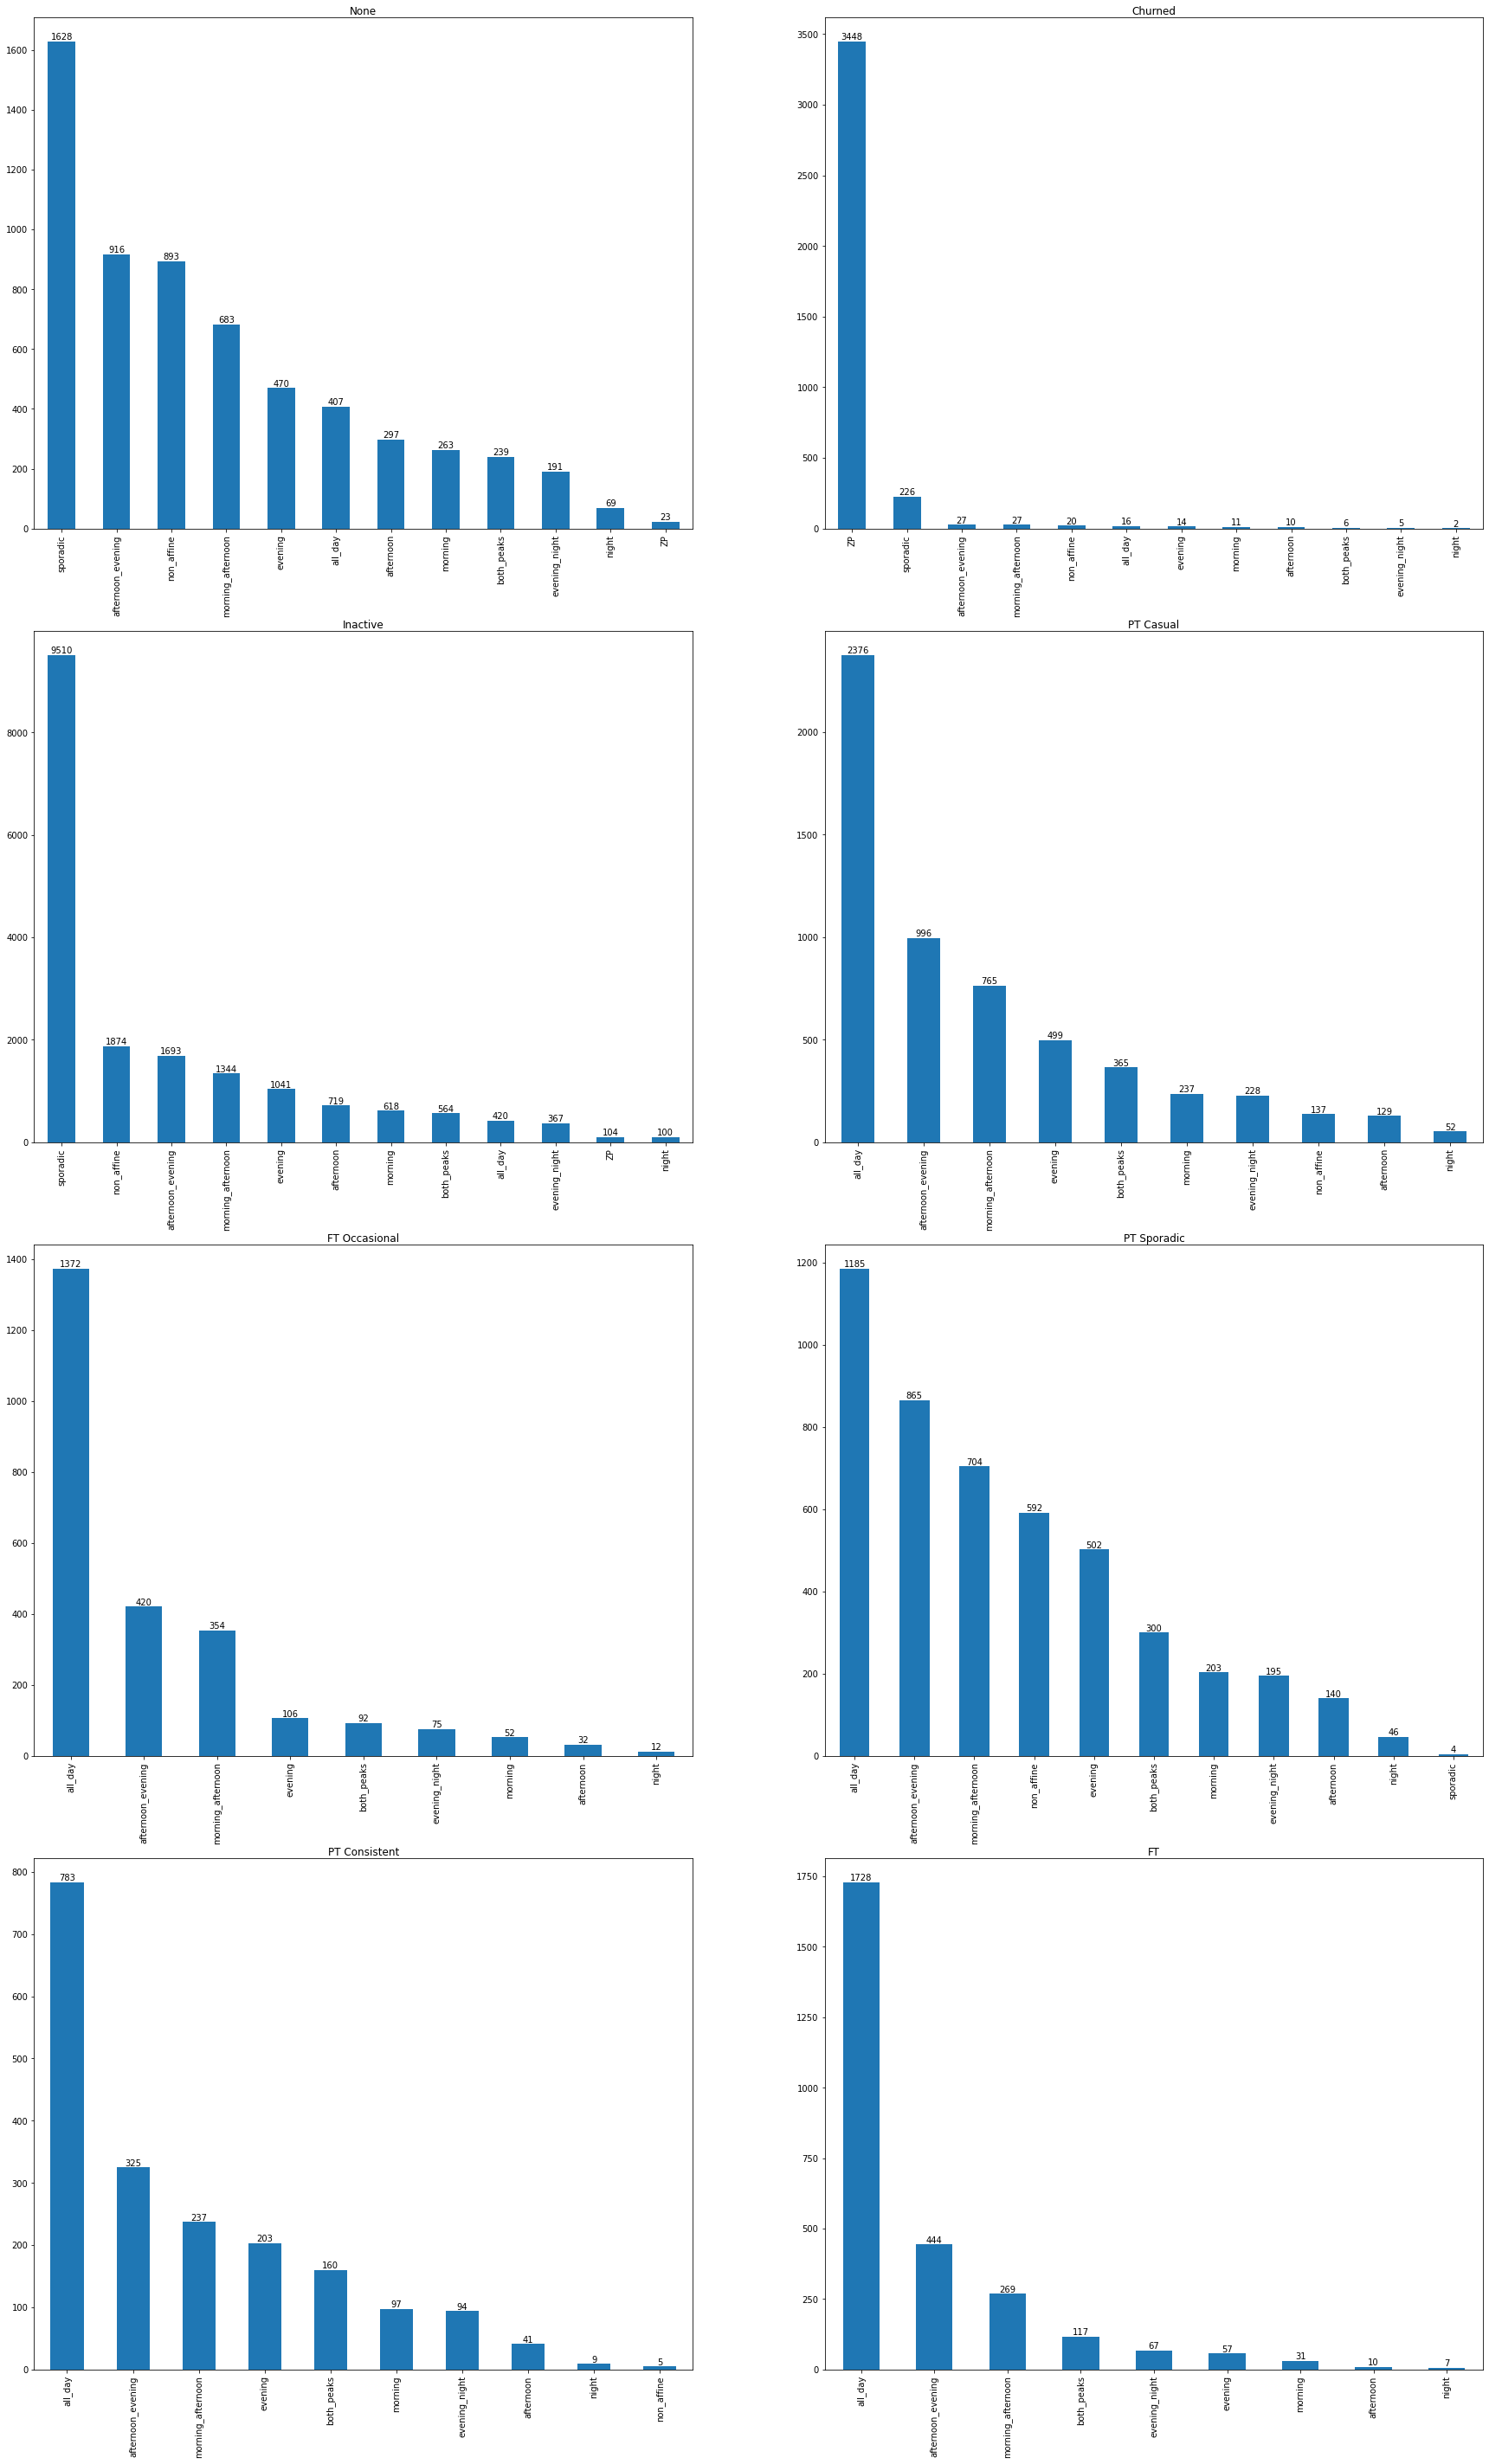

In [140]:
categorical_features = df_captains['captain_class'].unique()

rows = int(len(categorical_features)/2 if len(categorical_features)%2==0 else (len(categorical_features)+1)/2)
fig, axx = plt.subplots(rows, 2, figsize=(30, 50))

i, j = 0, 0
for cl in categorical_features:
    x = df_captains[df_captains['captain_class']==cl]['tod_affinity'].value_counts()
    x.plot(kind='bar', ax=axx[i,j]).set_title(cl,verticalalignment='top')
    
    rects = axx[i,j].patches

    for rect in rects:
        height = rect.get_height()
        axx[i,j].text(rect.get_x() + rect.get_width() / 2, height+0.01, '%d'%int(height),
                ha='center', va='bottom')
    
    if j == 1:
        j = 0
        i = i + 1
    else:
        j = j + 1

plt.show()

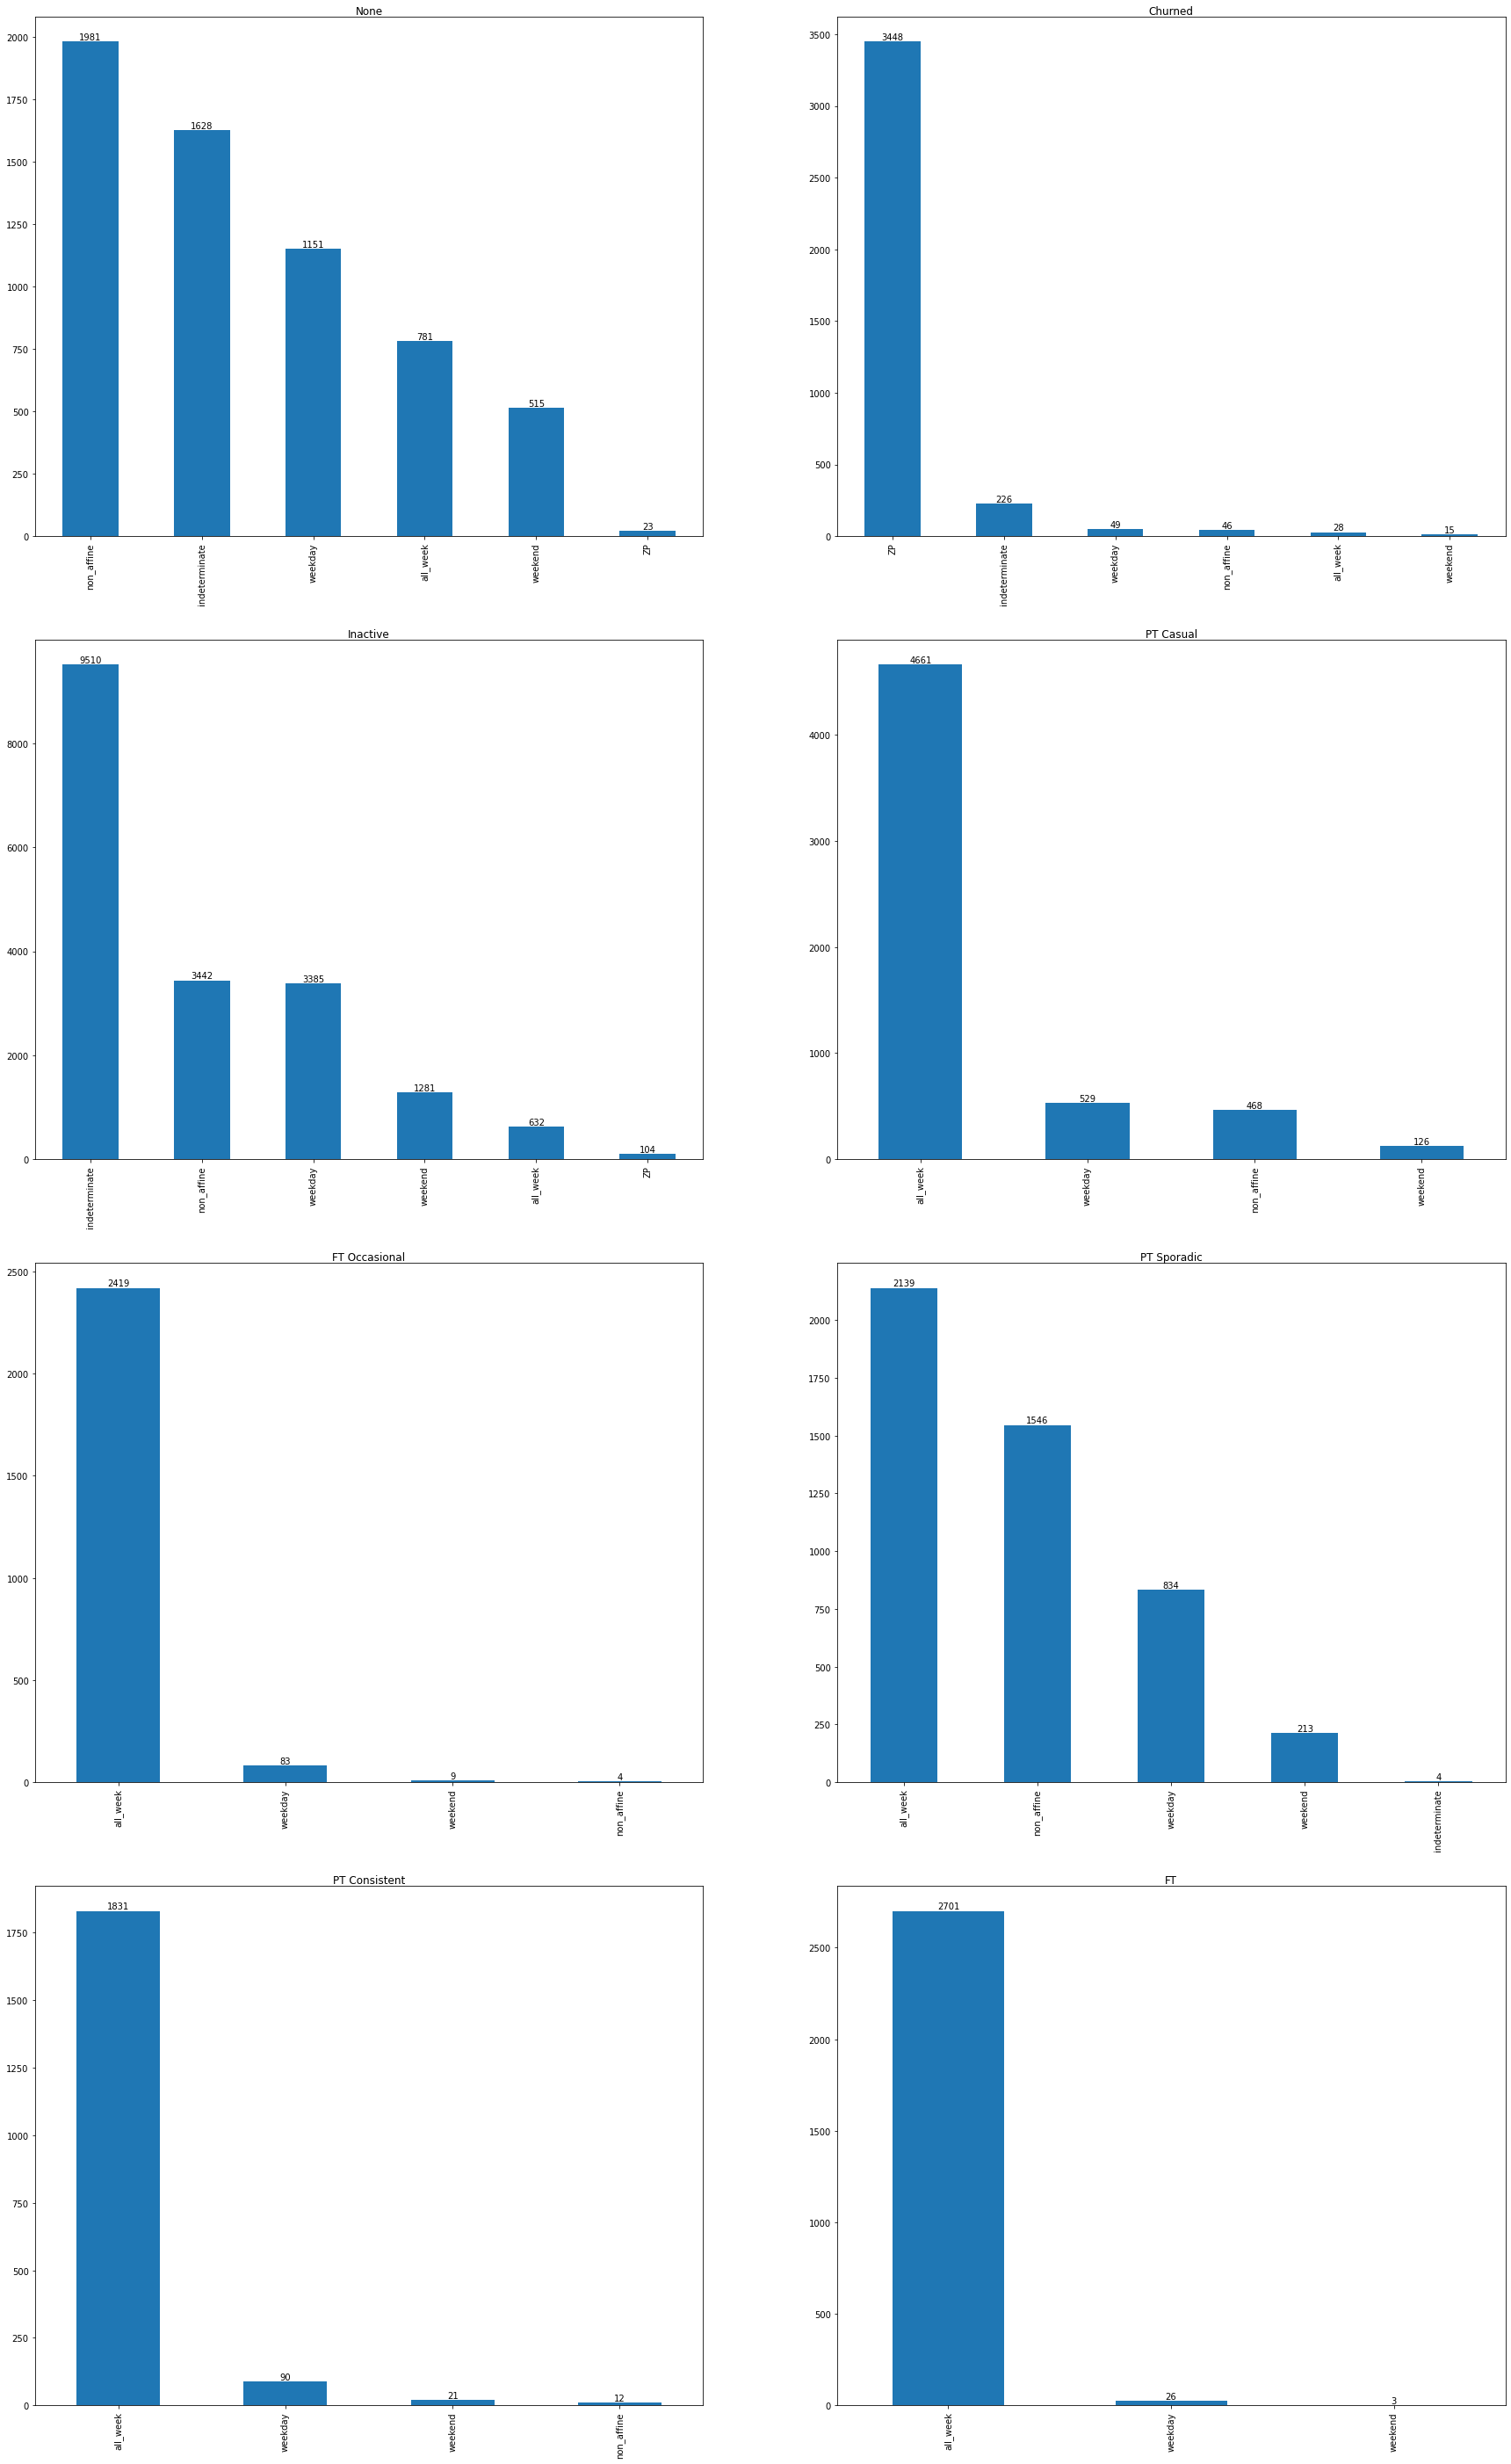

In [141]:
categorical_features = df_captains['captain_class'].unique()

rows = int(len(categorical_features)/2 if len(categorical_features)%2==0 else (len(categorical_features)+1)/2)
fig, axx = plt.subplots(rows, 2, figsize=(30, 50))

i, j = 0, 0
for cl in categorical_features:
    x = df_captains[df_captains['captain_class']==cl]['dow_affinity'].value_counts()
    x.plot(kind='bar', ax=axx[i,j]).set_title(cl,verticalalignment='top')
    
    rects = axx[i,j].patches

    for rect in rects:
        height = rect.get_height()
        axx[i,j].text(rect.get_x() + rect.get_width() / 2, height+0.01, '%d'%int(height),
                ha='center', va='bottom')
    
    if j == 1:
        j = 0
        i = i + 1
    else:
        j = j + 1

plt.show()

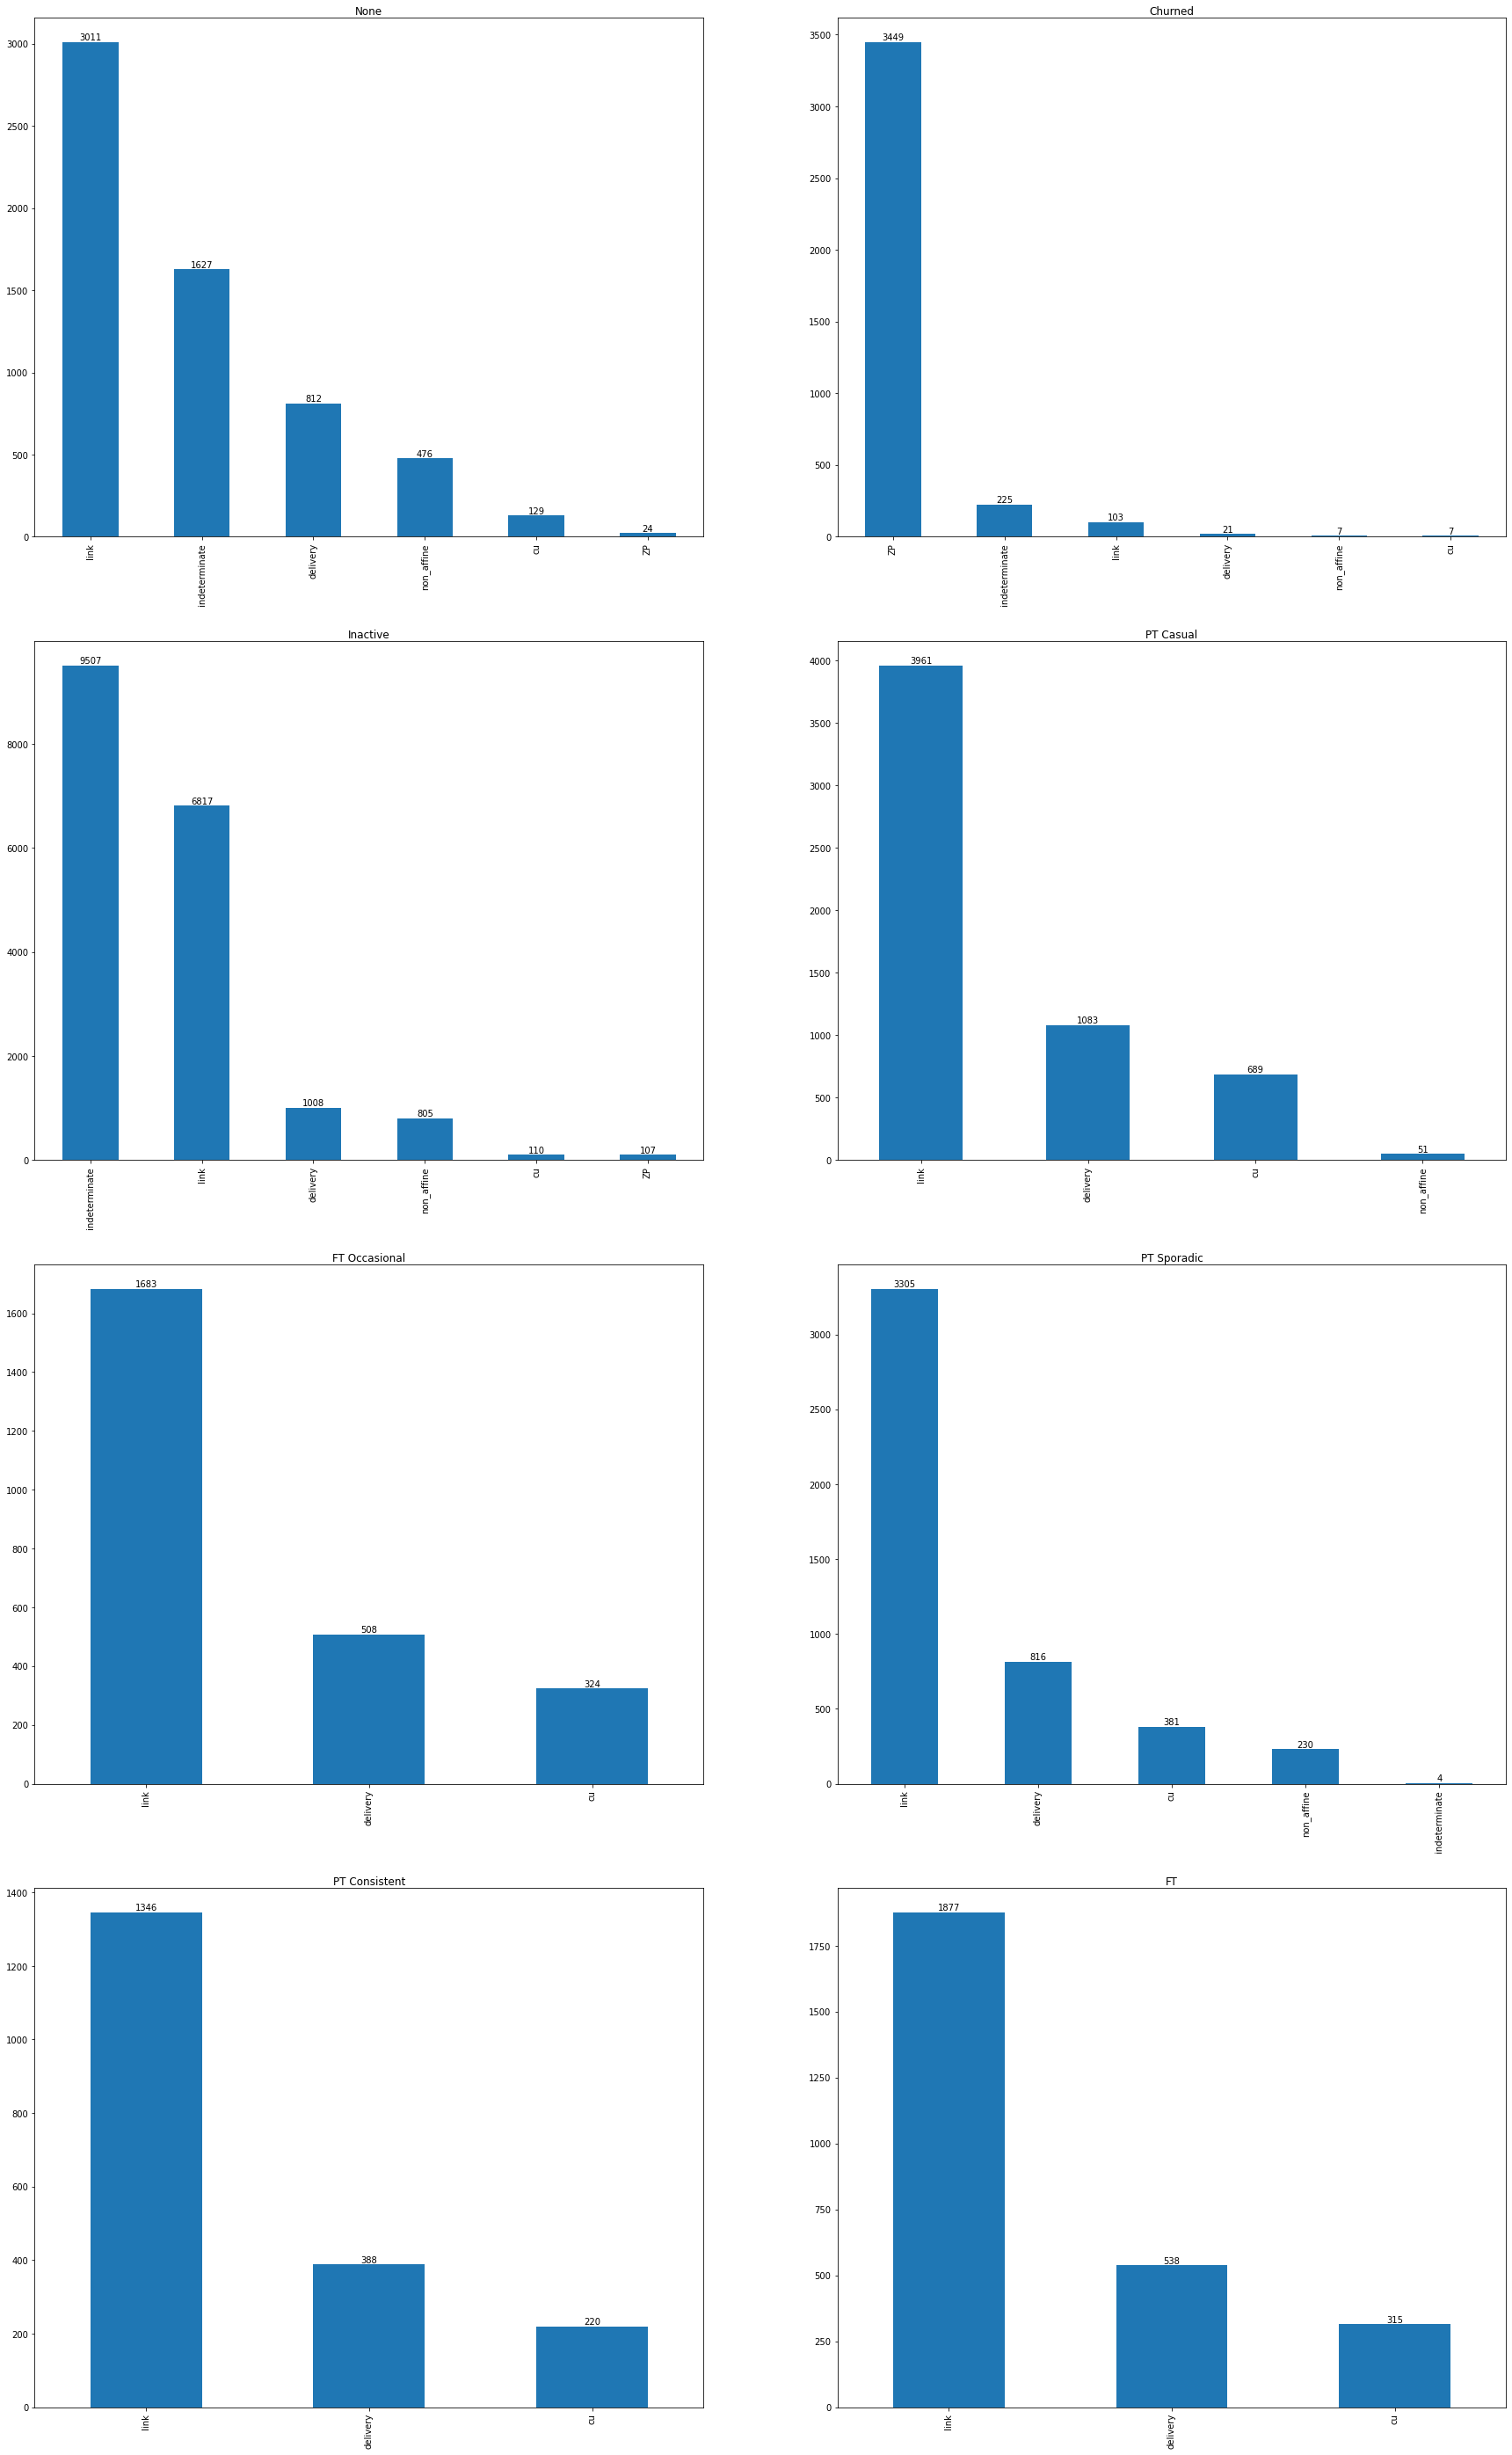

In [142]:
categorical_features = df_captains['captain_class'].unique()

rows = int(len(categorical_features)/2 if len(categorical_features)%2==0 else (len(categorical_features)+1)/2)
fig, axx = plt.subplots(rows, 2, figsize=(30, 50))

i, j = 0, 0
for cl in categorical_features:
    x = df_captains[df_captains['captain_class']==cl]['cu_affinity'].value_counts()
    x.plot(kind='bar', ax=axx[i,j]).set_title(cl,verticalalignment='top')
    
    rects = axx[i,j].patches

    for rect in rects:
        height = rect.get_height()
        axx[i,j].text(rect.get_x() + rect.get_width() / 2, height+0.01, '%d'%int(height),
                ha='center', va='bottom')
    
    if j == 1:
        j = 0
        i = i + 1
    else:
        j = j + 1

plt.show()

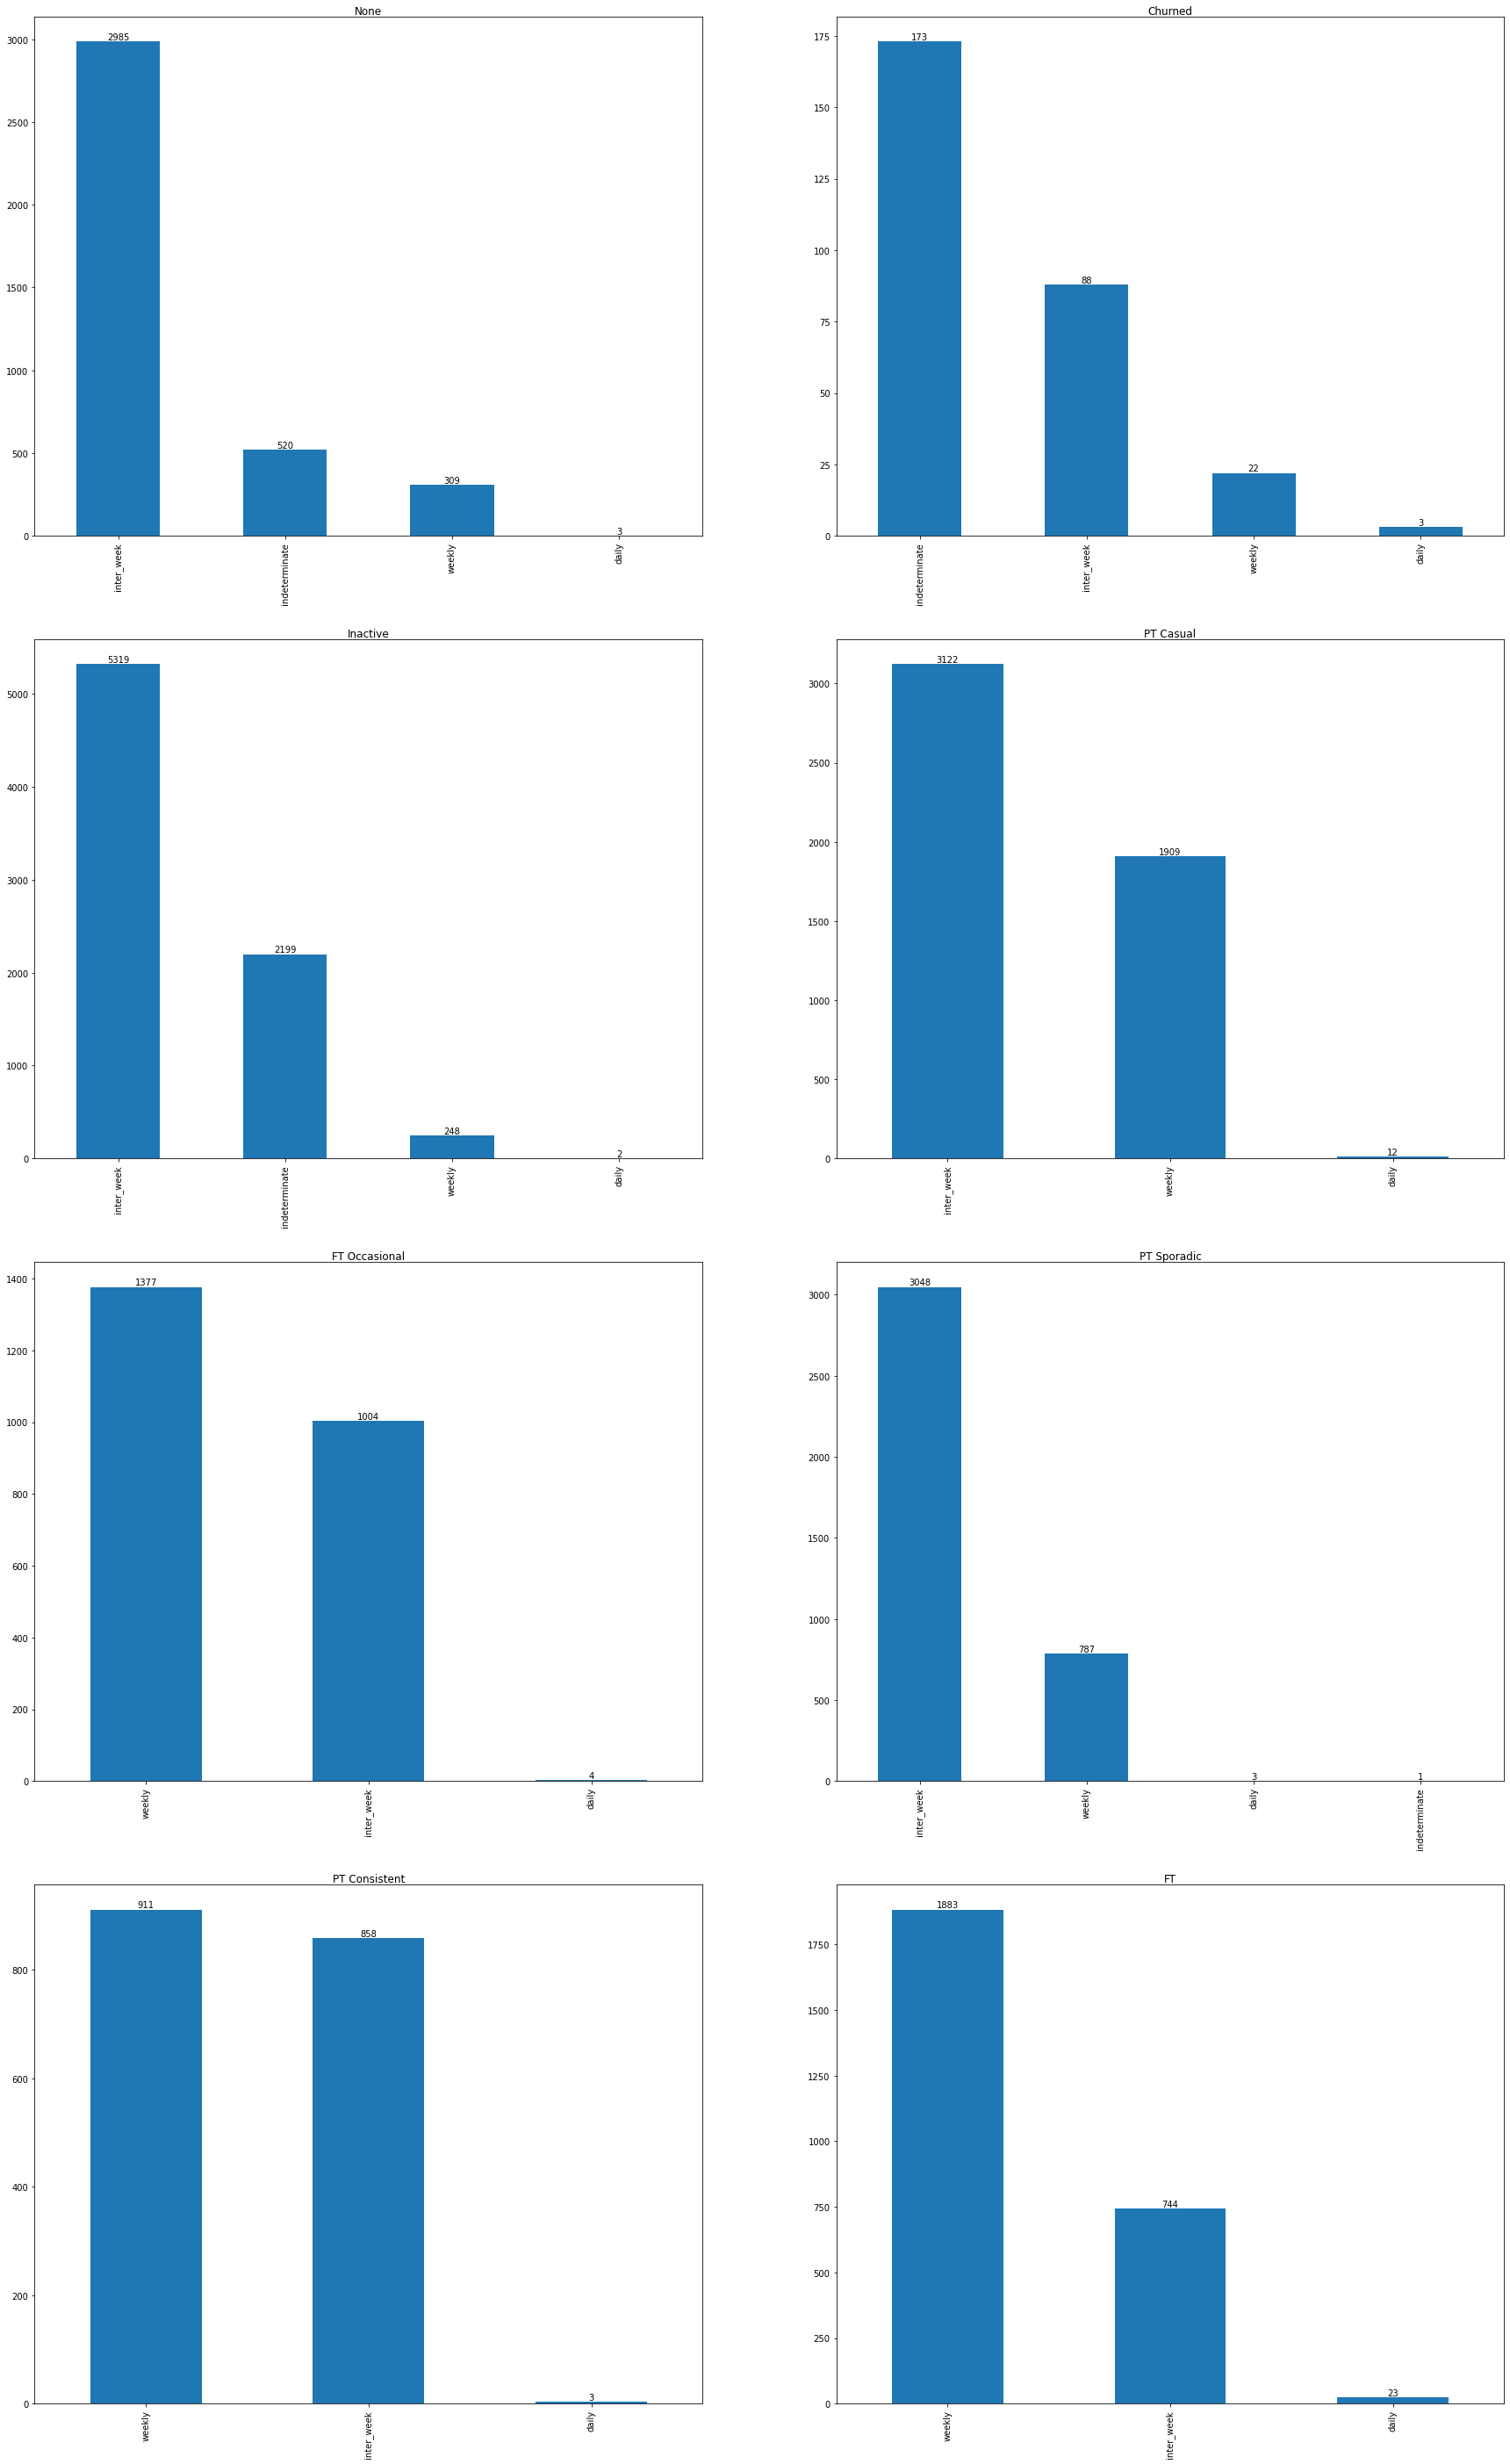

In [143]:
categorical_features = df_captains['captain_class'].unique()

rows = int(len(categorical_features)/2 if len(categorical_features)%2==0 else (len(categorical_features)+1)/2)
fig, axx = plt.subplots(rows, 2, figsize=(30, 50))

i, j = 0, 0
for cl in categorical_features:
    x = df_captains[df_captains['captain_class']==cl]['redeem_freq'].value_counts()
    x.plot(kind='bar', ax=axx[i,j]).set_title(cl,verticalalignment='top')
    
    rects = axx[i,j].patches

    for rect in rects:
        height = rect.get_height()
        axx[i,j].text(rect.get_x() + rect.get_width() / 2, height+0.01, '%d'%int(height),
                ha='center', va='bottom')
    
    if j == 1:
        j = 0
        i = i + 1
    else:
        j = j + 1

plt.show()

In [122]:
# check the rides done by captains in the first 2 weeks since activation

tmp = df_rides
tmp = tmp.merge(captains.rename(columns={'captainid':'captain_id'}), how = 'inner', on = 'captain_id')
tmp = tmp[tmp['week']-tmp['activation_week']<=2]
tmp.drop(['activationdate','activation_week'], axis=1, inplace=True)
tmp = tmp.groupby('captain_id').agg('sum').reset_index()
tmp = tmp[['captain_id','link_orders','delivery_orders','total_orders']]

tmp = tmp.merge(df_segment[['captainid','captain_class']].rename(columns={'captainid':'captain_id'}), how = 'inner', on = 'captain_id')

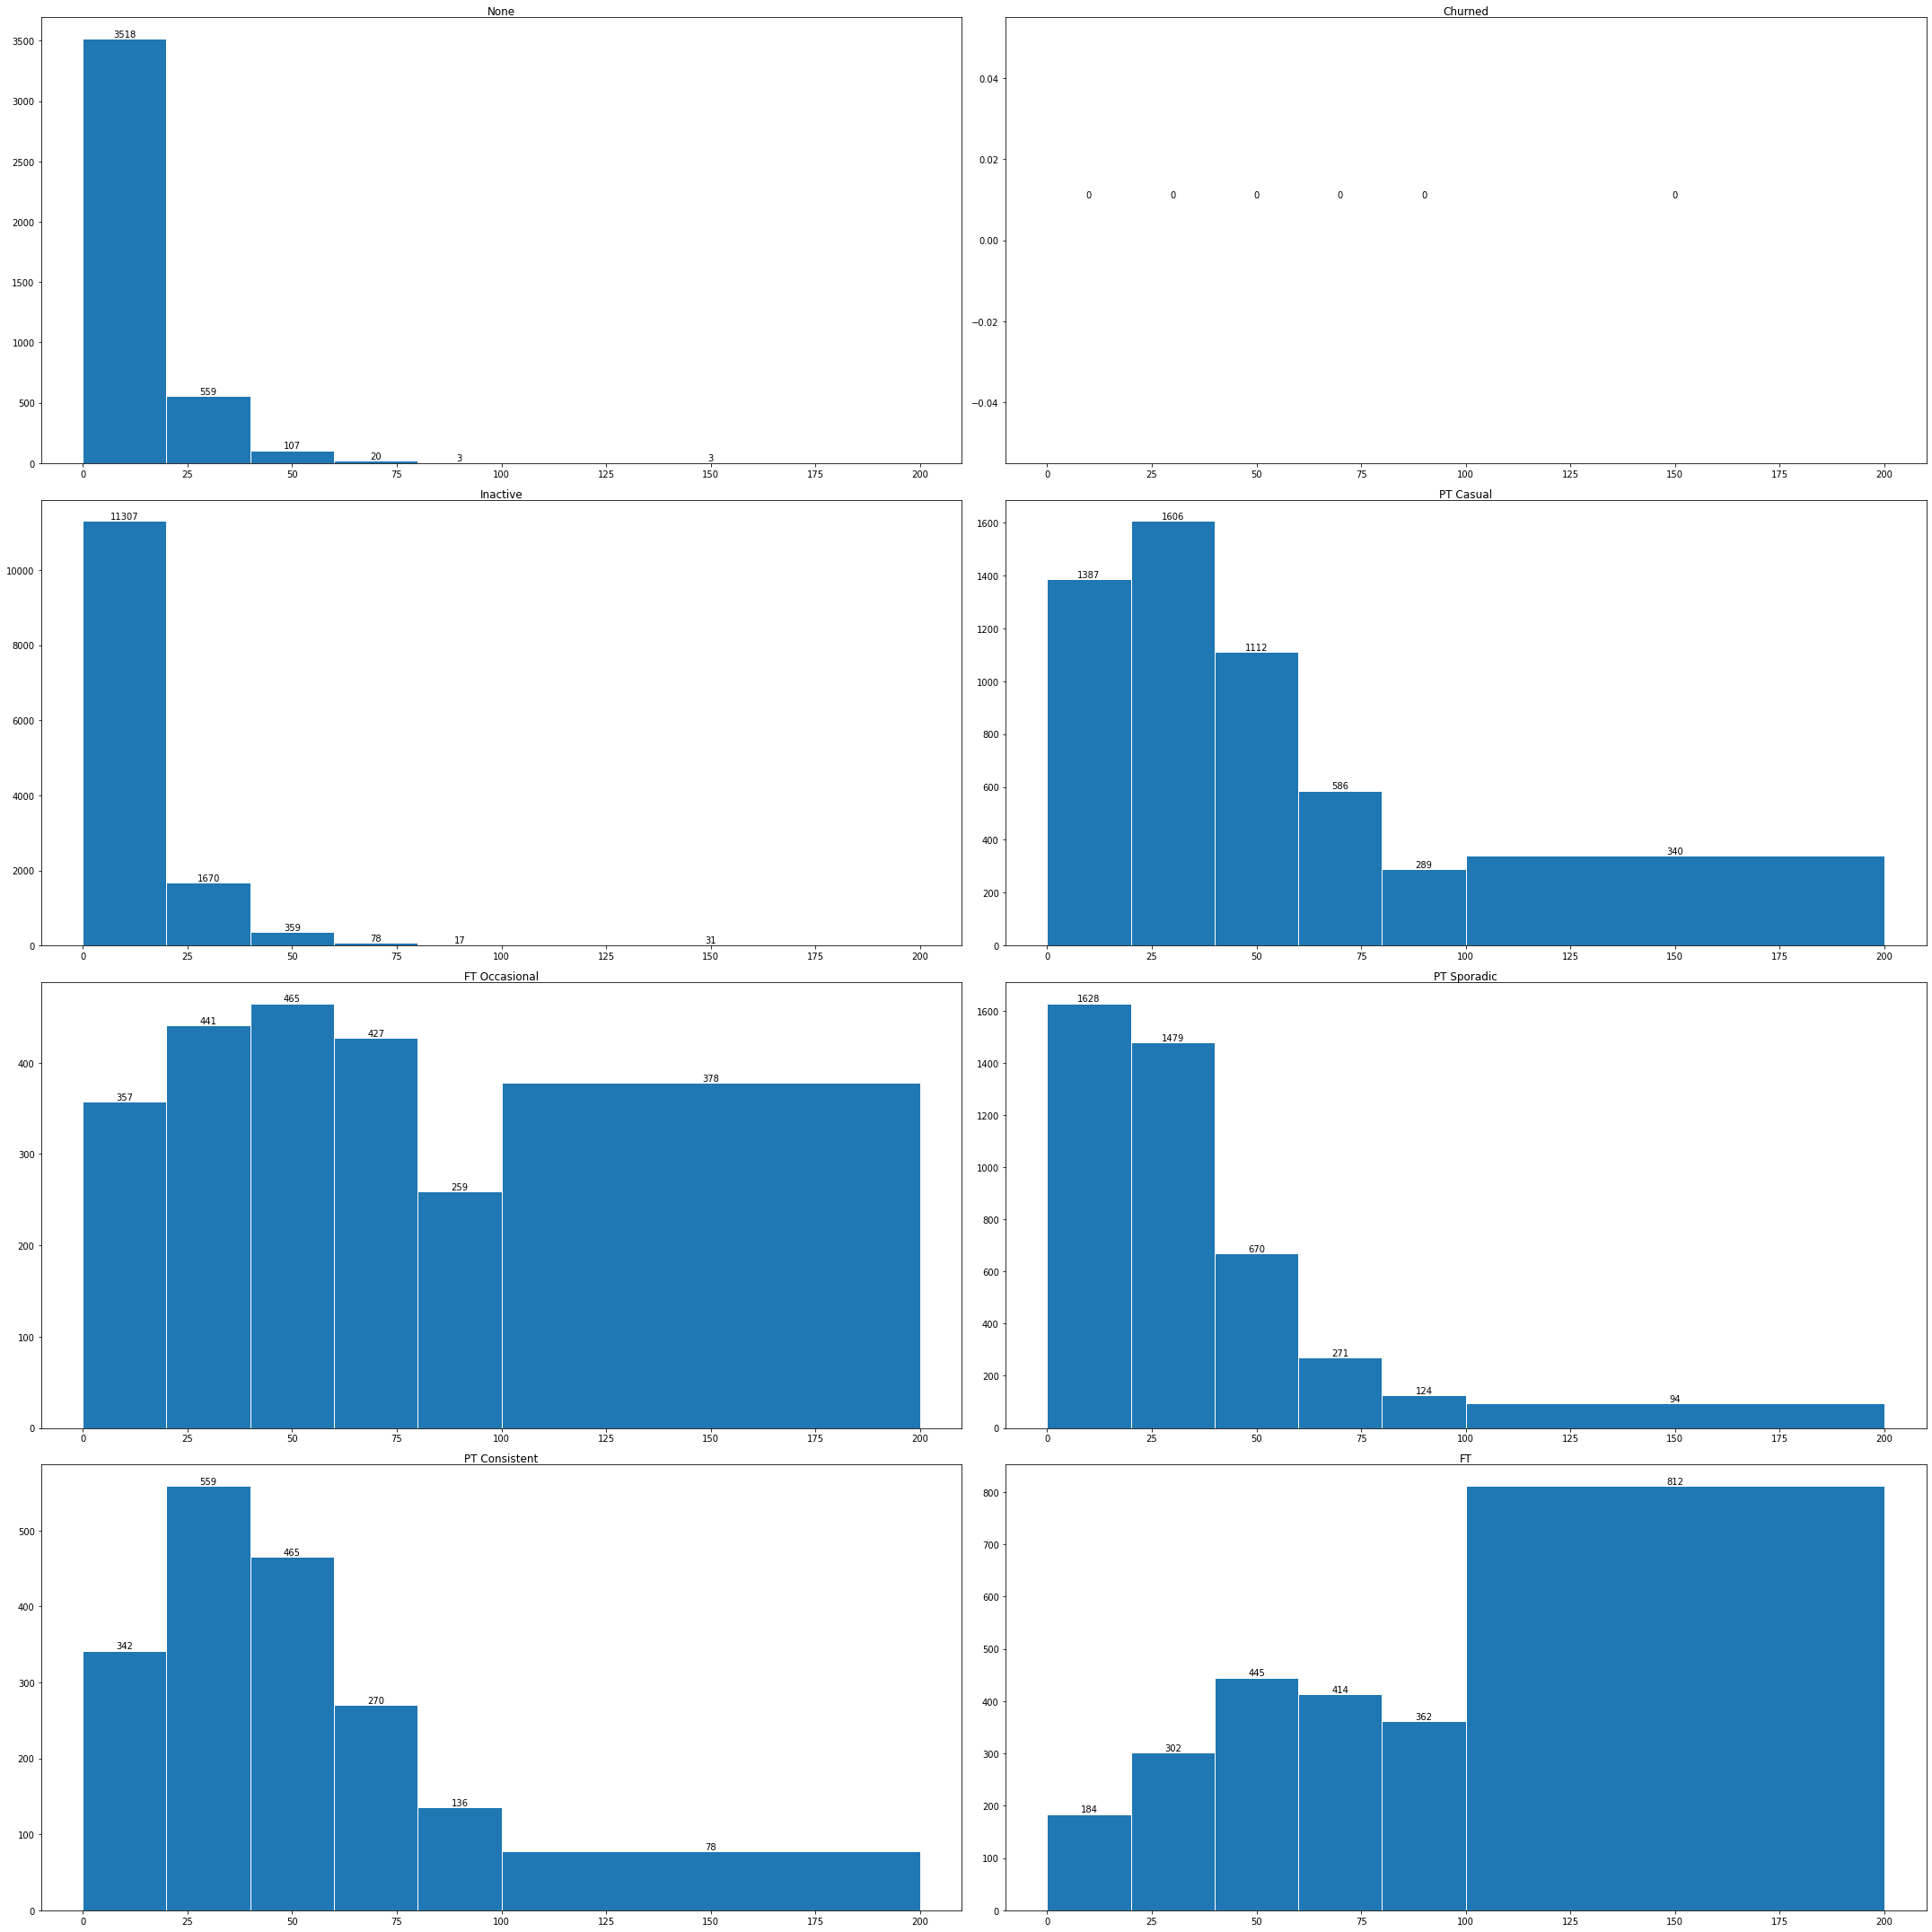

In [139]:
categorical_features = df_captains['captain_class'].unique()

rows = int(len(categorical_features)/2 if len(categorical_features)%2==0 else (len(categorical_features)+1)/2)
fig, axx = plt.subplots(rows, 2, figsize=(30, 30), tight_layout = True)

i, j = 0, 0
for cl in categorical_features:
    
    axx[i,j].hist(tmp[tmp['captain_class']==cl]['total_orders'], bins = [0,20,40,60,80,100,200], edgecolor='white')
    axx[i,j].set_title(cl,verticalalignment='top')

    rects = axx[i,j].patches

    for rect in rects:
        height = rect.get_height()
        axx[i,j].text(rect.get_x() + rect.get_width() / 2, height+0.01, '%d'%int(height),
                ha='center', va='bottom')
        
    if j == 1:
        j = 0
        i = i + 1
    else:
        j = j + 1
        
        
plt.show()

In [147]:
tmp = df_pings
tmp = tmp.merge(captains.rename(columns={'captainid':'captain_id'}), how = 'inner', on = 'captain_id')
tmp = tmp[tmp['week']-tmp['activation_week']<=2]
tmp.drop(['activationdate','activation_week'], axis=1, inplace=True)
tmp = tmp.groupby('captain_id').agg('sum').reset_index()
tmp['apr'] = round(tmp['accepted_pings']/tmp['Total_Pings']*100.0,2)
tmp['dpr'] = round(tmp['dropped_orders']/tmp['Total_Pings']*100.0,2)
tmp = tmp[['captain_id','apr','dpr','accepted_pings','Total_Pings','dropped_orders']]

tmp = tmp.merge(df_segment[['captainid','captain_class']].rename(columns={'captainid':'captain_id'}), how = 'inner', on = 'captain_id')

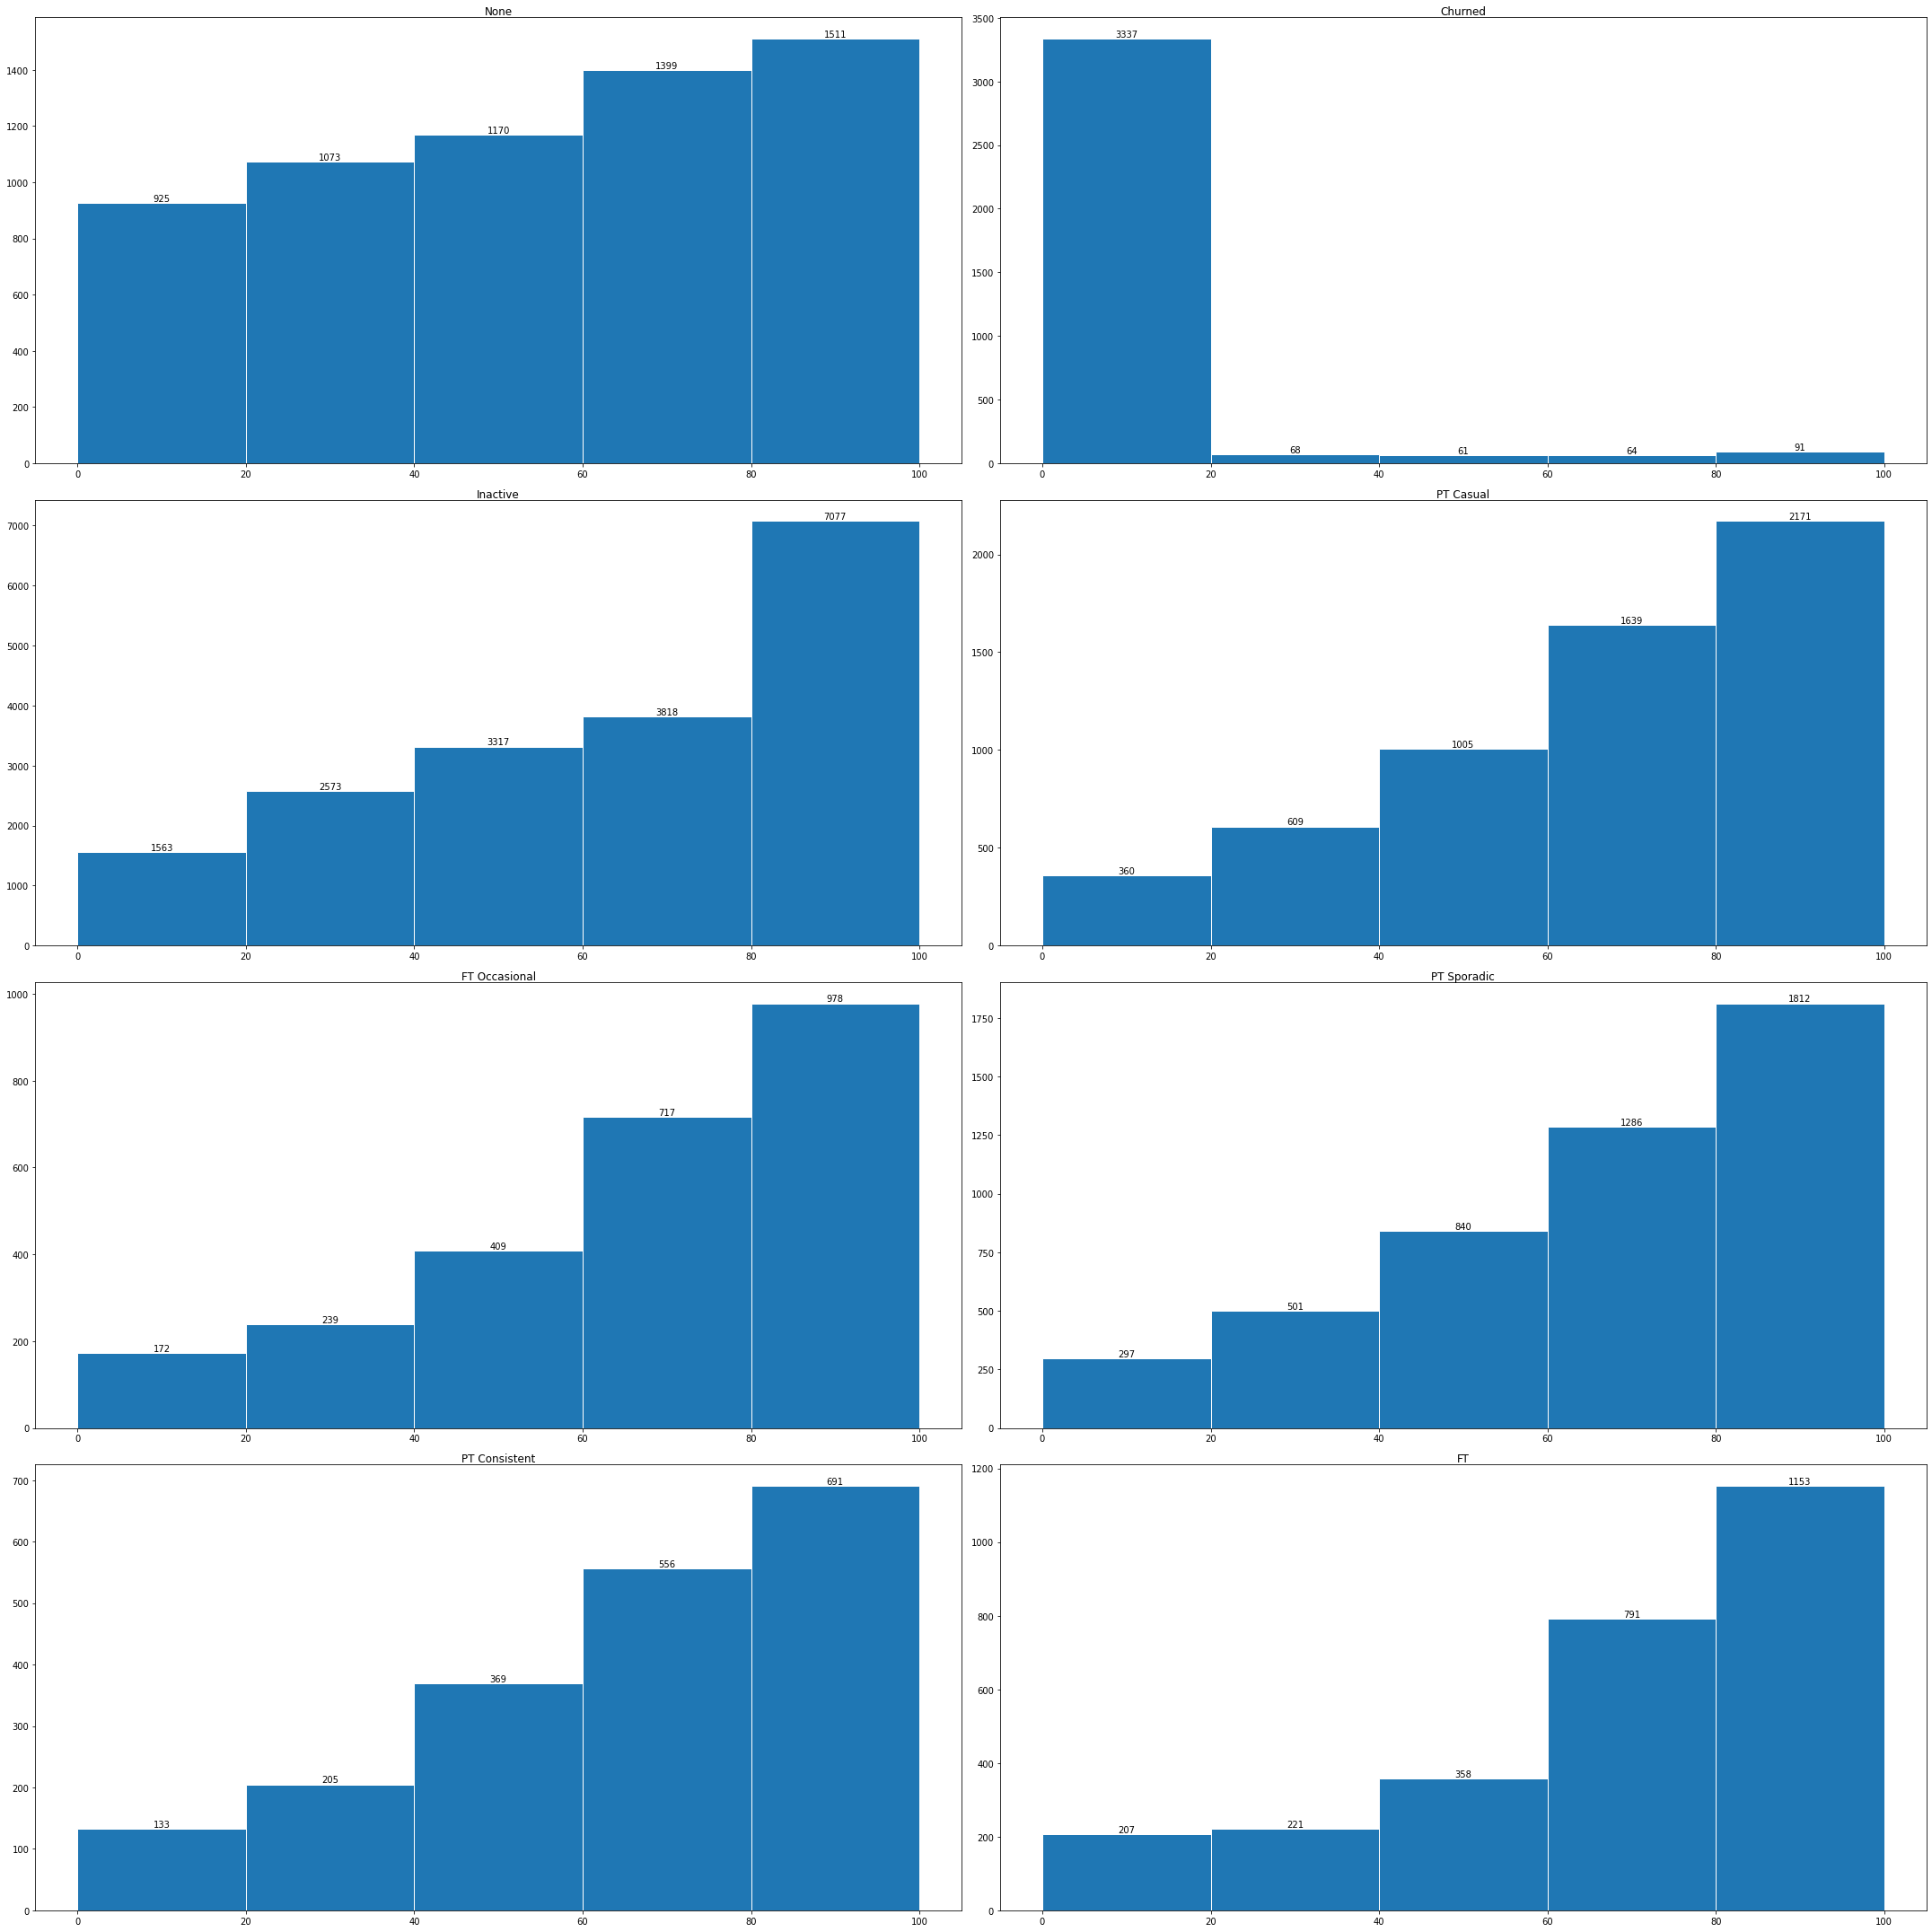

In [148]:
categorical_features = df_captains['captain_class'].unique()

rows = int(len(categorical_features)/2 if len(categorical_features)%2==0 else (len(categorical_features)+1)/2)
fig, axx = plt.subplots(rows, 2, figsize=(30, 30), tight_layout = True)

i, j = 0, 0
for cl in categorical_features:
    
    axx[i,j].hist(tmp[tmp['captain_class']==cl]['apr'], bins = [0,20,40,60,80,100], edgecolor='white')
    axx[i,j].set_title(cl,verticalalignment='top')

    rects = axx[i,j].patches

    for rect in rects:
        height = rect.get_height()
        axx[i,j].text(rect.get_x() + rect.get_width() / 2, height+0.01, '%d'%int(height),
                ha='center', va='bottom')
        
    if j == 1:
        j = 0
        i = i + 1
    else:
        j = j + 1
        
        
plt.show()

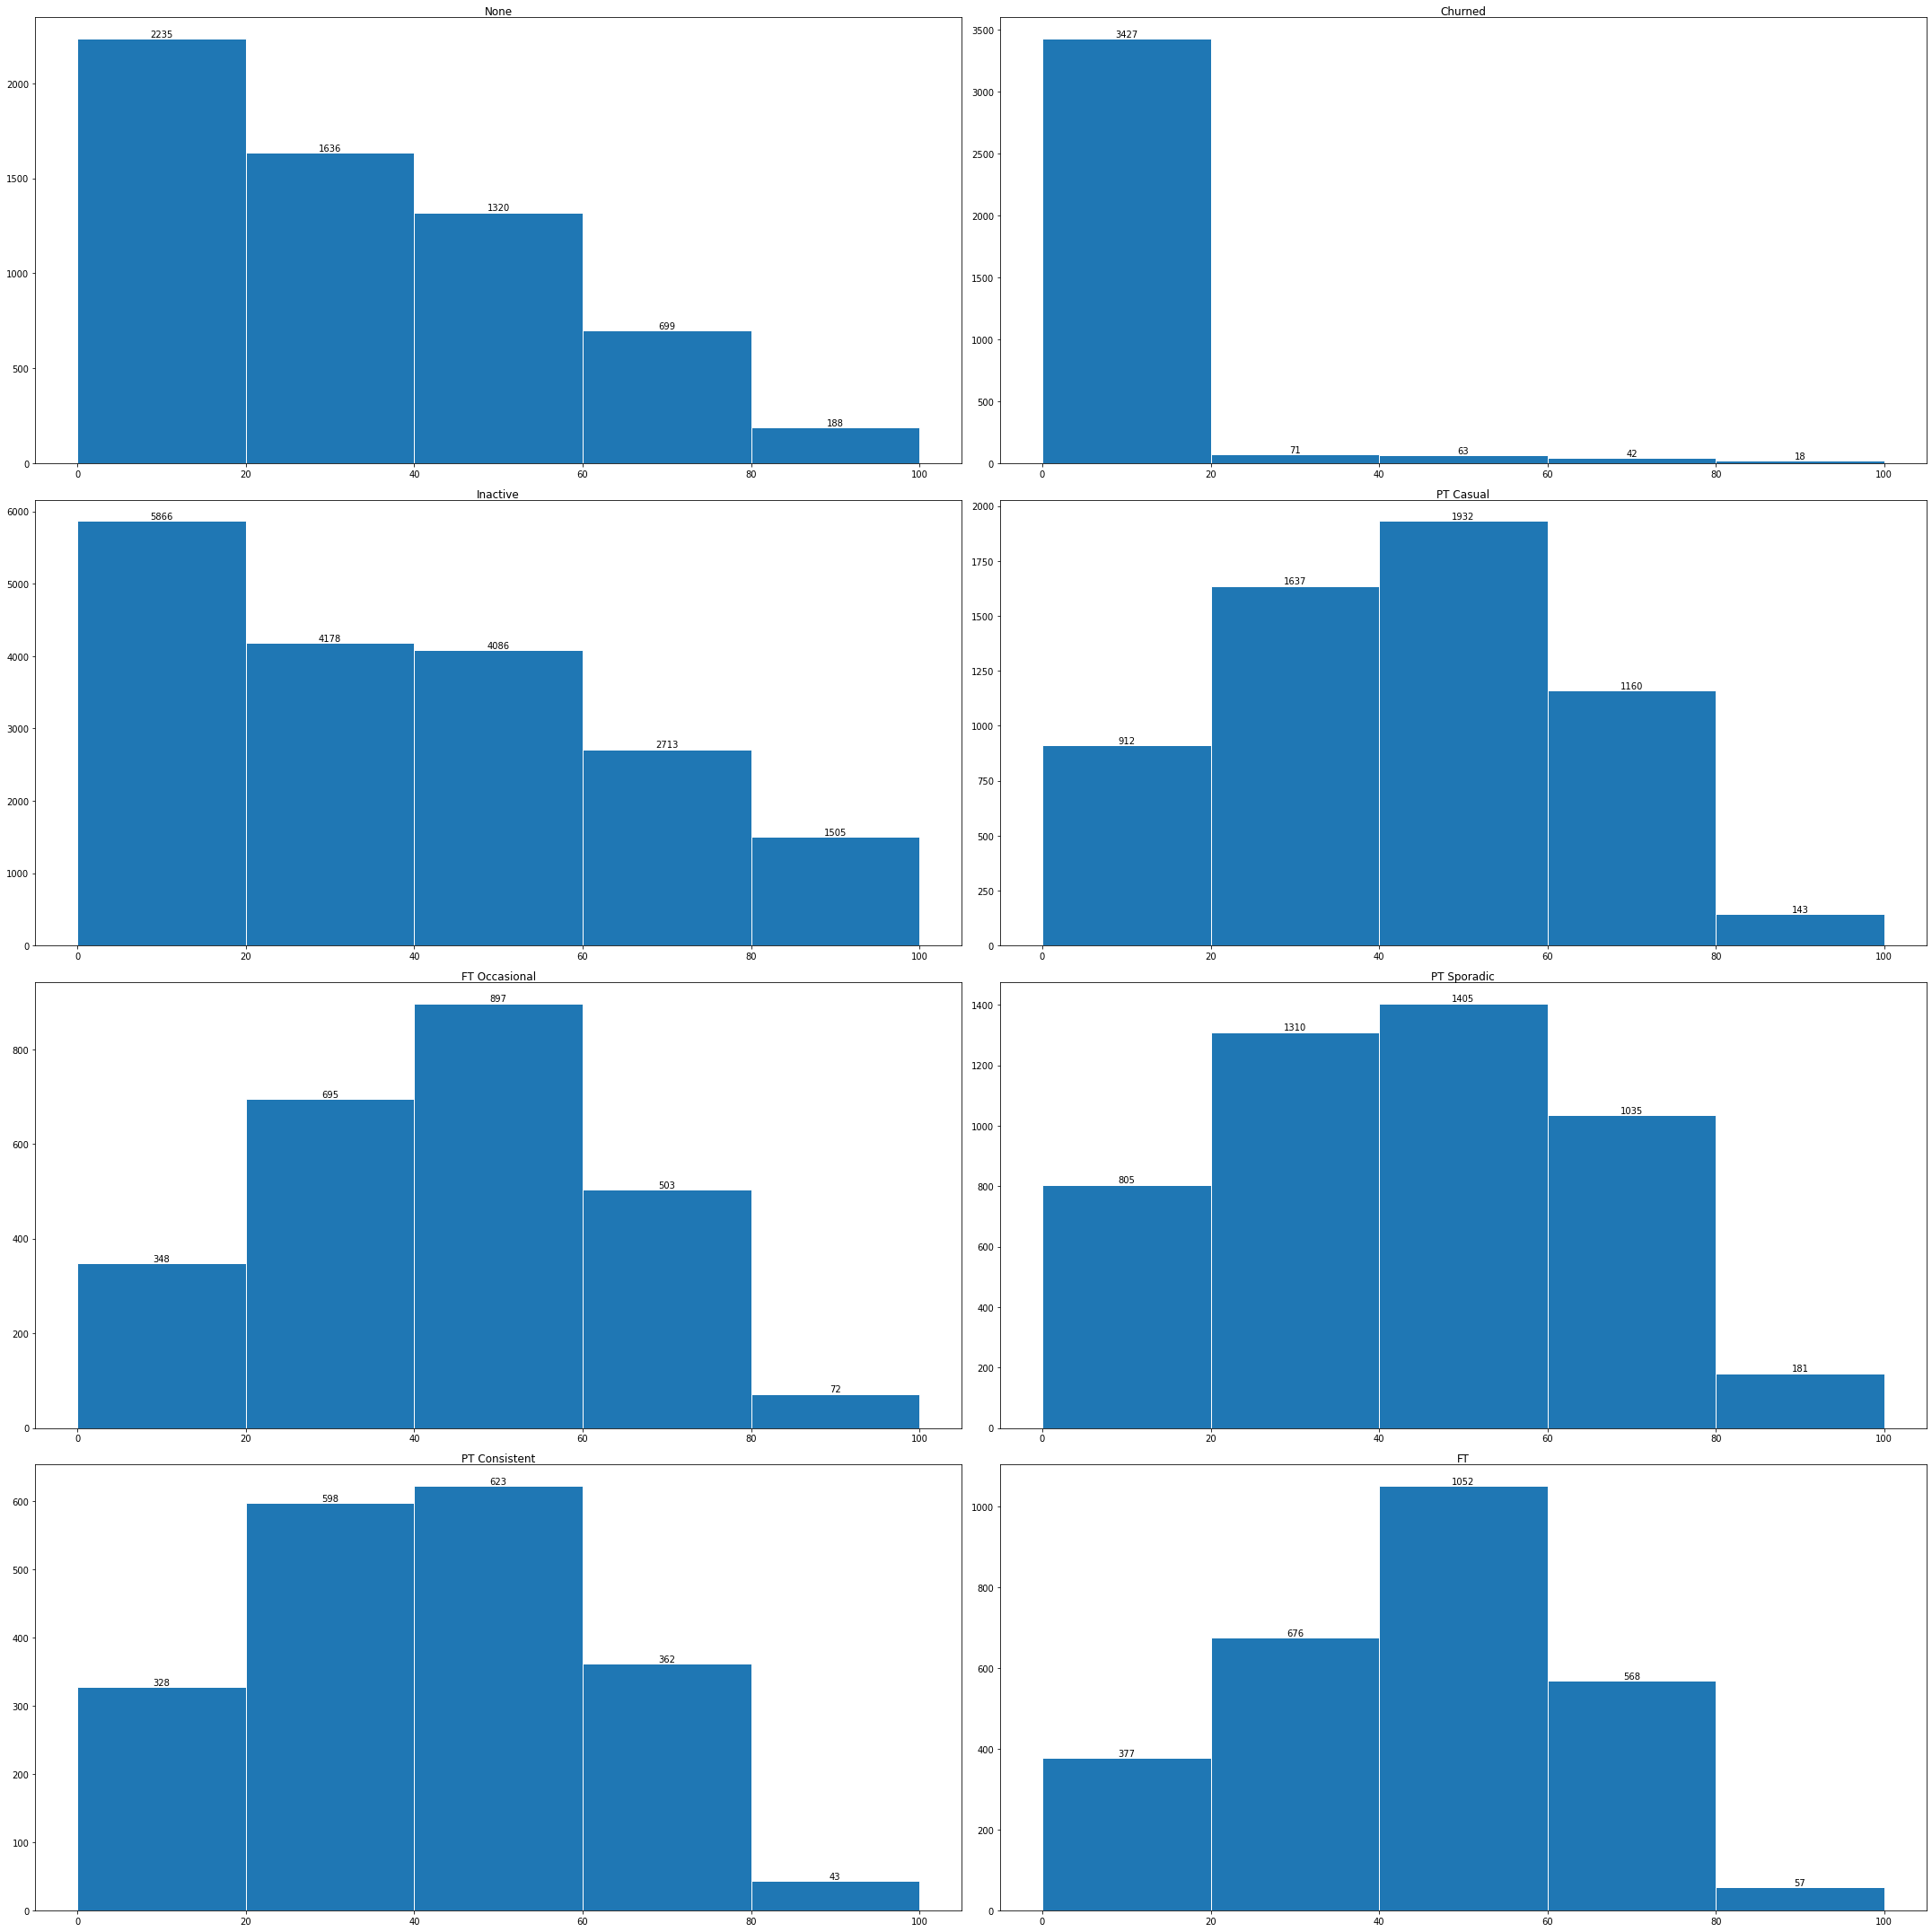

In [149]:
categorical_features = df_captains['captain_class'].unique()

rows = int(len(categorical_features)/2 if len(categorical_features)%2==0 else (len(categorical_features)+1)/2)
fig, axx = plt.subplots(rows, 2, figsize=(30, 30), tight_layout = True)

i, j = 0, 0
for cl in categorical_features:
    
    axx[i,j].hist(tmp[tmp['captain_class']==cl]['dpr'], bins = [0,20,40,60,80,100], edgecolor='white')
    axx[i,j].set_title(cl,verticalalignment='top')

    rects = axx[i,j].patches

    for rect in rects:
        height = rect.get_height()
        axx[i,j].text(rect.get_x() + rect.get_width() / 2, height+0.01, '%d'%int(height),
                ha='center', va='bottom')
        
    if j == 1:
        j = 0
        i = i + 1
    else:
        j = j + 1
        
        
plt.show()